In [1]:
# Data preparation and PLotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from datetime import datetime
import seaborn as sns
import matplotlib.dates as mdates
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

import yfinance  as yf
import pandas_datareader.data as pdr

import math

# Preprocessing and Machine Learning library
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import r2_score
import pyswarms as ps
import json

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Get Data

In [3]:
# Import các thư viện cần thiết
from datetime import datetime
import yfinance as yf

# Xác định ngày bắt đầu và ngày kết thúc
# - end_date: 15-11-2024.
# - start_date: Lấy dữ liệu từ 10-06-2013.
end_date = "2024-11-16"
start_date = "2013-07-10"

# Thông tin về công ty và mã cổ phiếu tương ứng
# - company_name: Danh sách tên các công ty (APPLE, GOOGLE, MICROSOFT, AMAZON).
# - stock_name: Danh sách mã cổ phiếu tương ứng (AAPL, GOOG, MSFT, AMZN).
company_name = ['APPLE', 'GOOGLE', 'AMAZON']
stock_name = ['AAPL', 'GOOG', 'AMZN']

# Lưu trữ dữ liệu cổ phiếu sau khi làm sạch
stock_data = {}
for i in range(len(stock_name)):
    # Tải dữ liệu cổ phiếu từ Yahoo Finance
    raw_data = yf.download(stock_name[i], start=start_date, end=end_date, auto_adjust=False)

    # Đặt lại tên các cột để loại bỏ đa cấp (multi-level indexing)
    raw_data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

    # Lọc ra các cột cần thiết: Giá điều chỉnh (Adj Close), giá đóng (Close), giá cao nhất (High), giá thấp nhất (Low), giá mở (Open), và khối lượng giao dịch (Volume).
    clean_data = raw_data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']]

    # Lưu dữ liệu đã làm sạch cho từng công ty vào từ điển
    stock_data[company_name[i]] = clean_data
    print(f"Cleaning data for {company_name[i]} has a size of: {clean_data.shape}")

# Lấy danh sách các ngày (index) từ dữ liệu của APPLE
# - date_time: Lưu trữ danh sách ngày, kiểu dữ liệu datetime.
date_time = stock_data['APPLE'].index

# Tạo các biến riêng cho từng công ty từ từ điển stock_data
# - AAPL, GOOG, MSFT, AMZN: Dữ liệu cổ phiếu tương ứng của từng công ty.
AAPL = stock_data['APPLE']
GOOG = stock_data['GOOGLE']
AMZN = stock_data['AMAZON']

[*********************100%***********************]  1 of 1 completed


Cleaning data for APPLE has a size of: (2860, 6)


[*********************100%***********************]  1 of 1 completed


Cleaning data for GOOGLE has a size of: (2860, 6)


[*********************100%***********************]  1 of 1 completed

Cleaning data for AMAZON has a size of: (2860, 6)


In [4]:
# Xem 5 dòng đầu tiên của dữ liệu cổ phiếu Apple
AAPL.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2013-07-10,12.889132,15.026071,15.171429,14.937500,14.985714,281405600
2013-07-11,13.090101,15.260357,15.294643,15.041786,15.105357,326292400
2013-07-12,13.066207,15.232500,15.349643,15.121786,15.273214,279563200
2013-07-15,13.094697,15.265714,15.409286,15.171429,15.178929,241917200
2013-07-16,13.179250,15.364286,15.382500,15.148929,15.232857,216538000


In [5]:
# Lệnh AAPL.shape:
# Trả về kích thước của DataFrame AAPL, bao gồm:
# - Số hàng (tương ứng với số ngày giao dịch có trong dữ liệu).
# - Số cột (tương ứng với các thông tin: Adj Close, Close, High, Low, Open, Volume).
AAPL.shape

# Lệnh print(AAPL):
# Hiển thị toàn bộ nội dung của DataFrame AAPL, bao gồm các cột:
# - Adj Close: Giá điều chỉnh (giá thực sau khi tính các yếu tố như chia cổ tức, chia tách cổ phiếu).
# - Close: Giá đóng cửa.
# - High: Giá cao nhất trong ngày.
# - Low: Giá thấp nhất trong ngày.
# - Open: Giá mở cửa.
# - Volume: Khối lượng cổ phiếu được giao dịch trong ngày.
# Dữ liệu được sắp xếp theo cột 'Date' (ngày giao dịch) làm chỉ mục.
print(AAPL)

             Adj Close       Close        High         Low        Open  \
Date                                                                     
2013-07-10   12.889132   15.026071   15.171429   14.937500   14.985714   
2013-07-11   13.090101   15.260357   15.294643   15.041786   15.105357   
2013-07-12   13.066207   15.232500   15.349643   15.121786   15.273214   
2013-07-15   13.094697   15.265714   15.409286   15.171429   15.178929   
2013-07-16   13.179250   15.364286   15.382500   15.148929   15.232857   
...                ...         ...         ...         ...         ...   
2024-11-11  223.220398  224.229996  225.699997  221.500000  225.000000   
2024-11-12  223.220398  224.229996  225.589996  223.360001  224.550003   
2024-11-13  224.106430  225.119995  226.649994  222.759995  224.009995   
2024-11-14  227.192459  228.220001  228.869995  225.000000  225.020004   
2024-11-15  223.986954  225.000000  226.919998  224.270004  226.399994   

               Volume  
Date         

In [6]:
# Lệnh AAPL.describe():
# - Trả về các thống kê mô tả cơ bản của DataFrame AAPL (cho từng cột số).
# - Các giá trị được tính trên toàn bộ dữ liệu.

# Các thống kê bao gồm:
# - count: Số lượng giá trị không bị thiếu trong từng cột.
# - mean: Giá trị trung bình.
# - std: Độ lệch chuẩn (Standard Deviation).
# - min: Giá trị nhỏ nhất.
# - 25%: Phân vị thứ 25 (Q1).
# - 50%: Phân vị thứ 50 (Median - Trung vị).
# - 75%: Phân vị thứ 75 (Q3).
# - max: Giá trị lớn nhất.
AAPL.describe()

,Adj Close,Close,High,Low,Open,Volume
count,2860.000000,2860.000000,2860.000000,2860.000000,2860.000000,2.860000e+03
mean,82.468323,85.008941,85.841007,84.095942,84.942051,1.392285e+08
std,64.372753,64.224516,64.843271,63.534550,64.168339,9.650720e+07
min,12.835829,14.963929,15.171429,14.937500,14.985714,2.404830e+07
25%,26.611879,29.264999,29.502500,29.020000,29.230625,7.615540e+07
50%,48.388906,50.542500,50.966249,50.002501,50.407501,1.097452e+08
75%,143.395821,146.352505,147.802494,144.854996,146.062504,1.730995e+08
max,235.156540,236.479996,237.490005,234.449997,236.479996,1.065523e+09


In [7]:
# Lệnh AAPL.info():
# - Cung cấp thông tin tổng quan về DataFrame AAPL, bao gồm:
#   1. Số lượng hàng và cột.
#   2. Tên các cột trong DataFrame.
#   3. Số lượng giá trị không bị thiếu (non-null) trong từng cột.
#   4. Kiểu dữ liệu (dtype) của mỗi cột.
#   5. Tổng kích thước bộ nhớ được sử dụng bởi DataFrame.
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2013-07-10 to 2024-11-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2860 non-null   float64
 1   Close      2860 non-null   float64
 2   High       2860 non-null   float64
 3   Low        2860 non-null   float64
 4   Open       2860 non-null   float64
 5   Volume     2860 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 156.4 KB


### Prepare Vinamilk Data

In [8]:
# đọc dữ liệu từ file csv
df_vnm = pd.read_csv('../../DATASET/PRICE/Vinamilk_Stock_Adjusted.csv')

# Xóa cột "Thay đổi %" từ DataFrame dataSet
df_vnm = df_vnm.drop(columns=["Change"])

# Hiển thị lại DataFrame sau khi xóa
print(df_vnm)

            Date    Close     Open     High      Low   Volume    Adj Close
0     15/11/2024  63205.4  64396.1  64396.1  63205.4  3690000  63205.39400
1     14/11/2024  64495.3  64495.3  64495.3  64197.7  1780000  64495.30000
2     13/11/2024  64495.3  64594.6  65090.7  64197.7  2770000  64492.69415
3     12/11/2024  64396.1  64693.8  65189.9  64296.9  1730000  64396.20852
4     11/11/2024  64693.8  65189.9  65289.1  64197.7  2740000  64694.45676
...          ...      ...      ...      ...      ...      ...          ...
2831  16/07/2013  96528.0  95139.0  97222.0  95139.0   729690  96528.02940
2832  15/07/2013  95139.0  95139.0  95833.0  94444.0   176980  95139.00000
2833  12/07/2013  95139.0  94444.0  95139.0  93750.0   220820  95142.88560
2834  11/07/2013  94444.0  94444.0  95139.0  93750.0   161840  94444.00000
2835  10/07/2013  94444.0  95139.0  95833.0  94444.0   232110          NaN

[2836 rows x 7 columns]


In [9]:
df_vnm = df_vnm.iloc[::-1].reset_index(drop=True)

### Data preprocessing

In [10]:
# Chuyển đổi cột "Ngày" sang dạng datetime
df_vnm['Date'] = pd.to_datetime(df_vnm['Date'], dayfirst=True)

df_vnm['Date'] = df_vnm['Date'].dt.strftime('%Y/%m/%d')
# Chuyển đổi lại cột "Ngày" sang kiểu datetime
df_vnm['Date'] = pd.to_datetime(df_vnm['Date'], format='%Y/%m/%d')
# Sắp xếp lại dữ liệu theo thứ tự thời gian
df_vnm = df_vnm.sort_values(by='Date')

In [13]:
# def convert_to_float(value):
#     value = value.replace(',', '')  # Loại bỏ dấu phẩy nếu có
#     if "M" in value:
#         return float(value.replace("M", "")) * 1e6
#     elif "K" in value:
#         return float(value.replace("K", "")) * 1e3
#     else:
#         return float(value)

# # Chuyển đổi định dạng các cột giá thành số thực
# df['Close'] = df['Close'].str.replace(',', '').astype(float)
# df['Open'] = df['Open'].str.replace(',', '').astype(float)
# df['High'] = df['High'].str.replace(',', '').astype(float)
# df['Low'] = df['Low'].str.replace(',', '').astype(float)
# df['KL'] = df['KL'].apply(convert_to_float)

In [11]:
#kích thước dữ liệu
df_vnm.shape

(2836, 7)

In [12]:
#dữ liệu 5 dòng đầu
df_vnm.head()

,Date,Close,Open,High,Low,Volume,Adj Close
0,2013-07-10,94444.0,95139.0,95833.0,94444.0,232110,NaN
1,2013-07-11,94444.0,94444.0,95139.0,93750.0,161840,94444.0000
2,2013-07-12,95139.0,94444.0,95139.0,93750.0,220820,95142.8856
3,2013-07-15,95139.0,95139.0,95833.0,94444.0,176980,95139.0000
4,2013-07-16,96528.0,95139.0,97222.0,95139.0,729690,96528.0294


In [16]:
#xác định kiểu dữ liệu
df_vnm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2836 entries, 0 to 2835
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2836 non-null   datetime64[ns]
 1   Close      2836 non-null   float64       
 2   Open       2836 non-null   float64       
 3   High       2836 non-null   float64       
 4   Low        2836 non-null   float64       
 5   Volume     2836 non-null   int64         
 6   Adj Close  2835 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 155.2 KB


In [13]:
df_vnm.isnull().sum()

Date         0
Close        0
Open         0
High         0
Low          0
Volume       0
Adj Close    1
dtype: int64

In [14]:
df_vnm['Adj Close'].fillna(method='ffill')

0               NaN
1       94444.00000
2       95142.88560
3       95139.00000
4       96528.02940
           ...     
2831    64694.45676
2832    64396.20852
2833    64492.69415
2834    64495.30000
2835    63205.39400
Name: Adj Close, Length: 2836, dtype: float64

### Creates 4 line charts (one for each company's stock price) displayed in a large canvas. Each chart shows the stock's 'Adj Close' price over time.

In [15]:
VNM = df_vnm.copy()
stock_data['VINAMILK'] = VNM 

# Dữ liệu cổ phiếu được lấy trong khoảng thời gian từ 10-07-2013 đến 15-01-2025, bắt đầu từ {start_date.year} (năm {start_date.year}) đến thời điểm hiện tại ({end_date.year}).

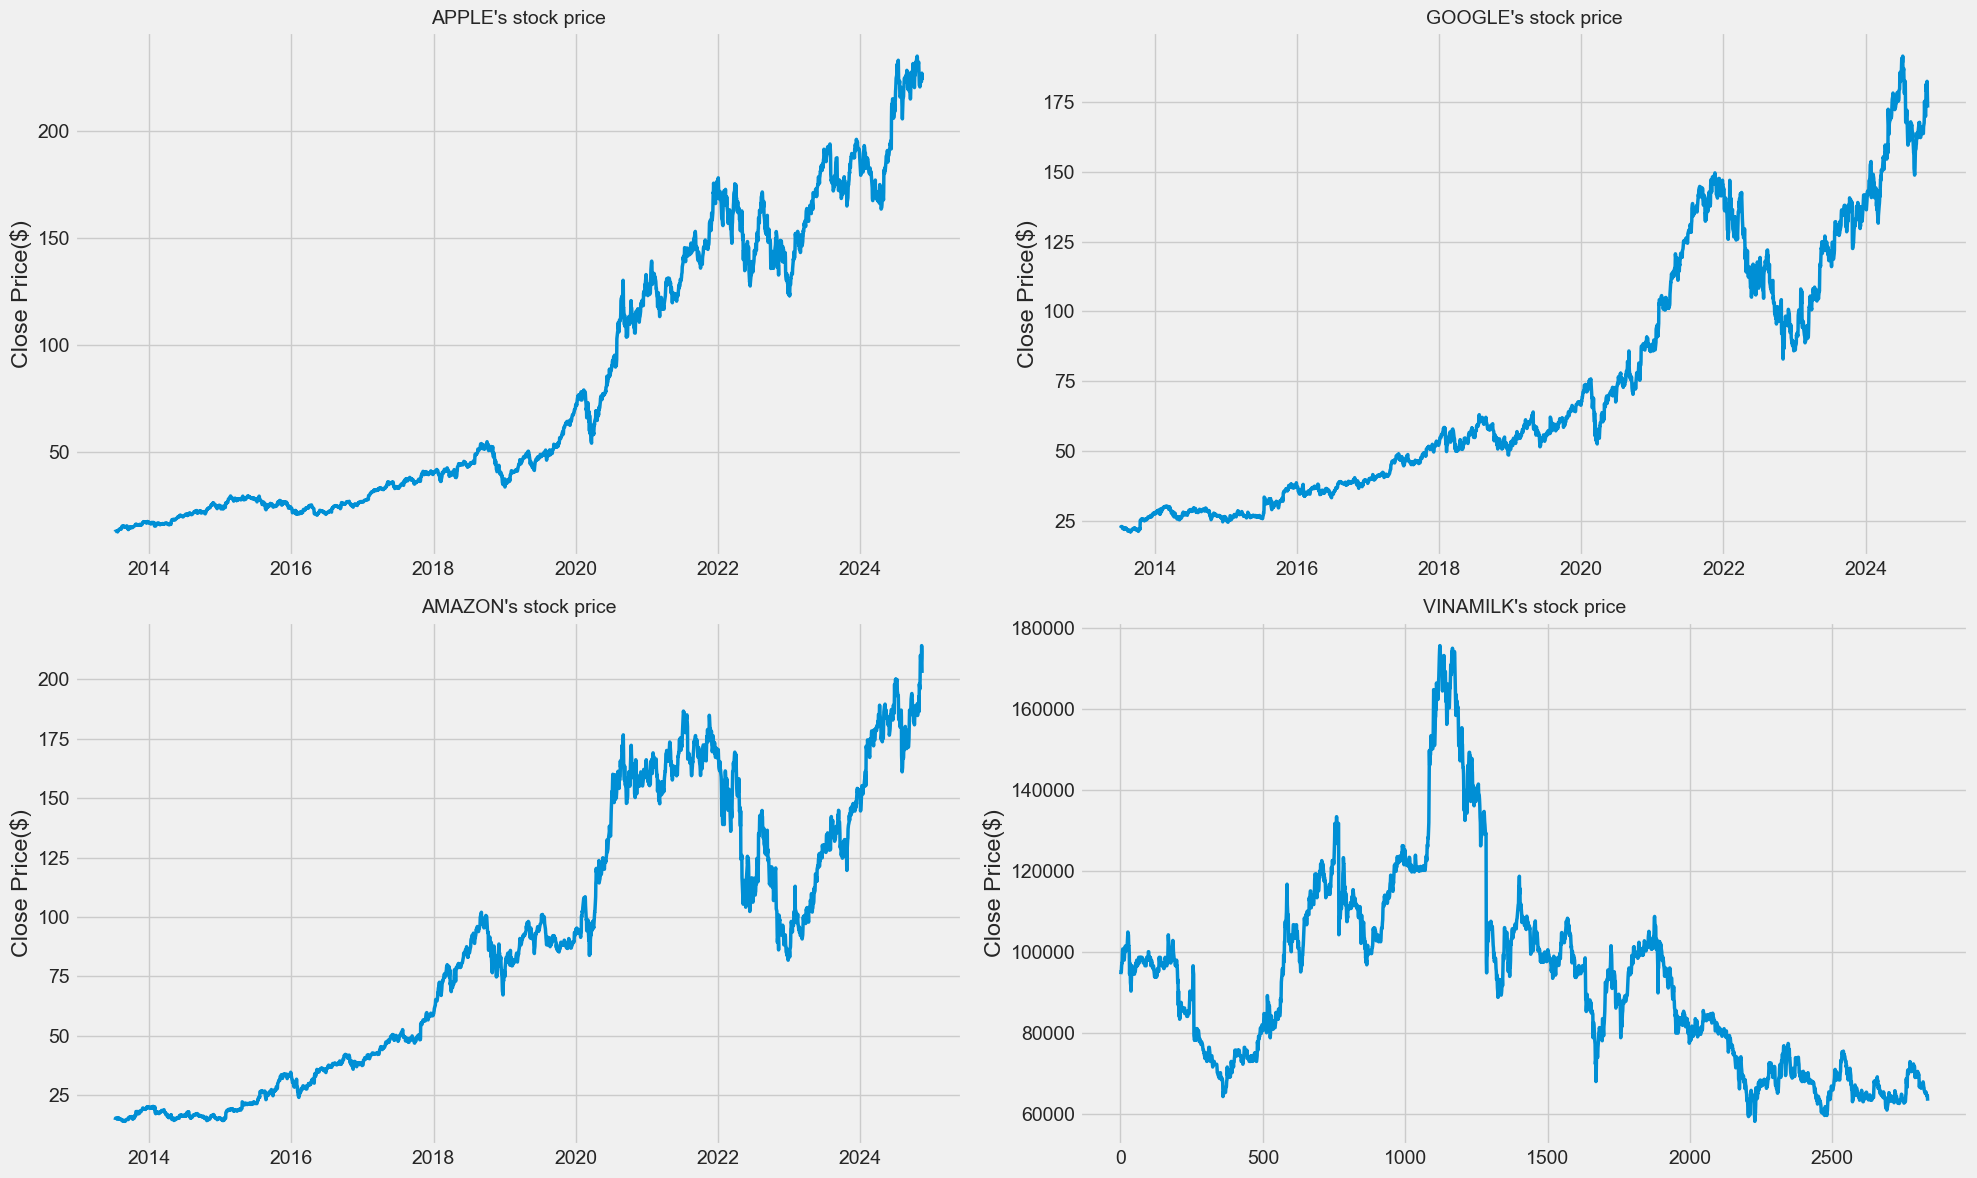

In [16]:
company_list = list(stock_data.keys())  # Danh sách các công ty
num_companies = len(company_list)  # Số công ty
rows = math.ceil(num_companies / 2)  # Tính số hàng tự động (mỗi hàng 2 biểu đồ)

plt.figure(figsize = (20, 12))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, name in enumerate(company_list, 1):
    plt.subplot(rows,2,i)
    sns.lineplot(stock_data[name]['Adj Close'], linewidth = 2.5)
    plt.xlabel(None)
    plt.ylabel('Close Price($)')
    plt.title(f"{name}'s stock price", fontsize = 14)

plt.tight_layout()

### Create 4 line charts, each showing the stock's trading volume (Volume) over time. The charts are placed in a 2x2 grid and adjusted to display neatly without overlap.

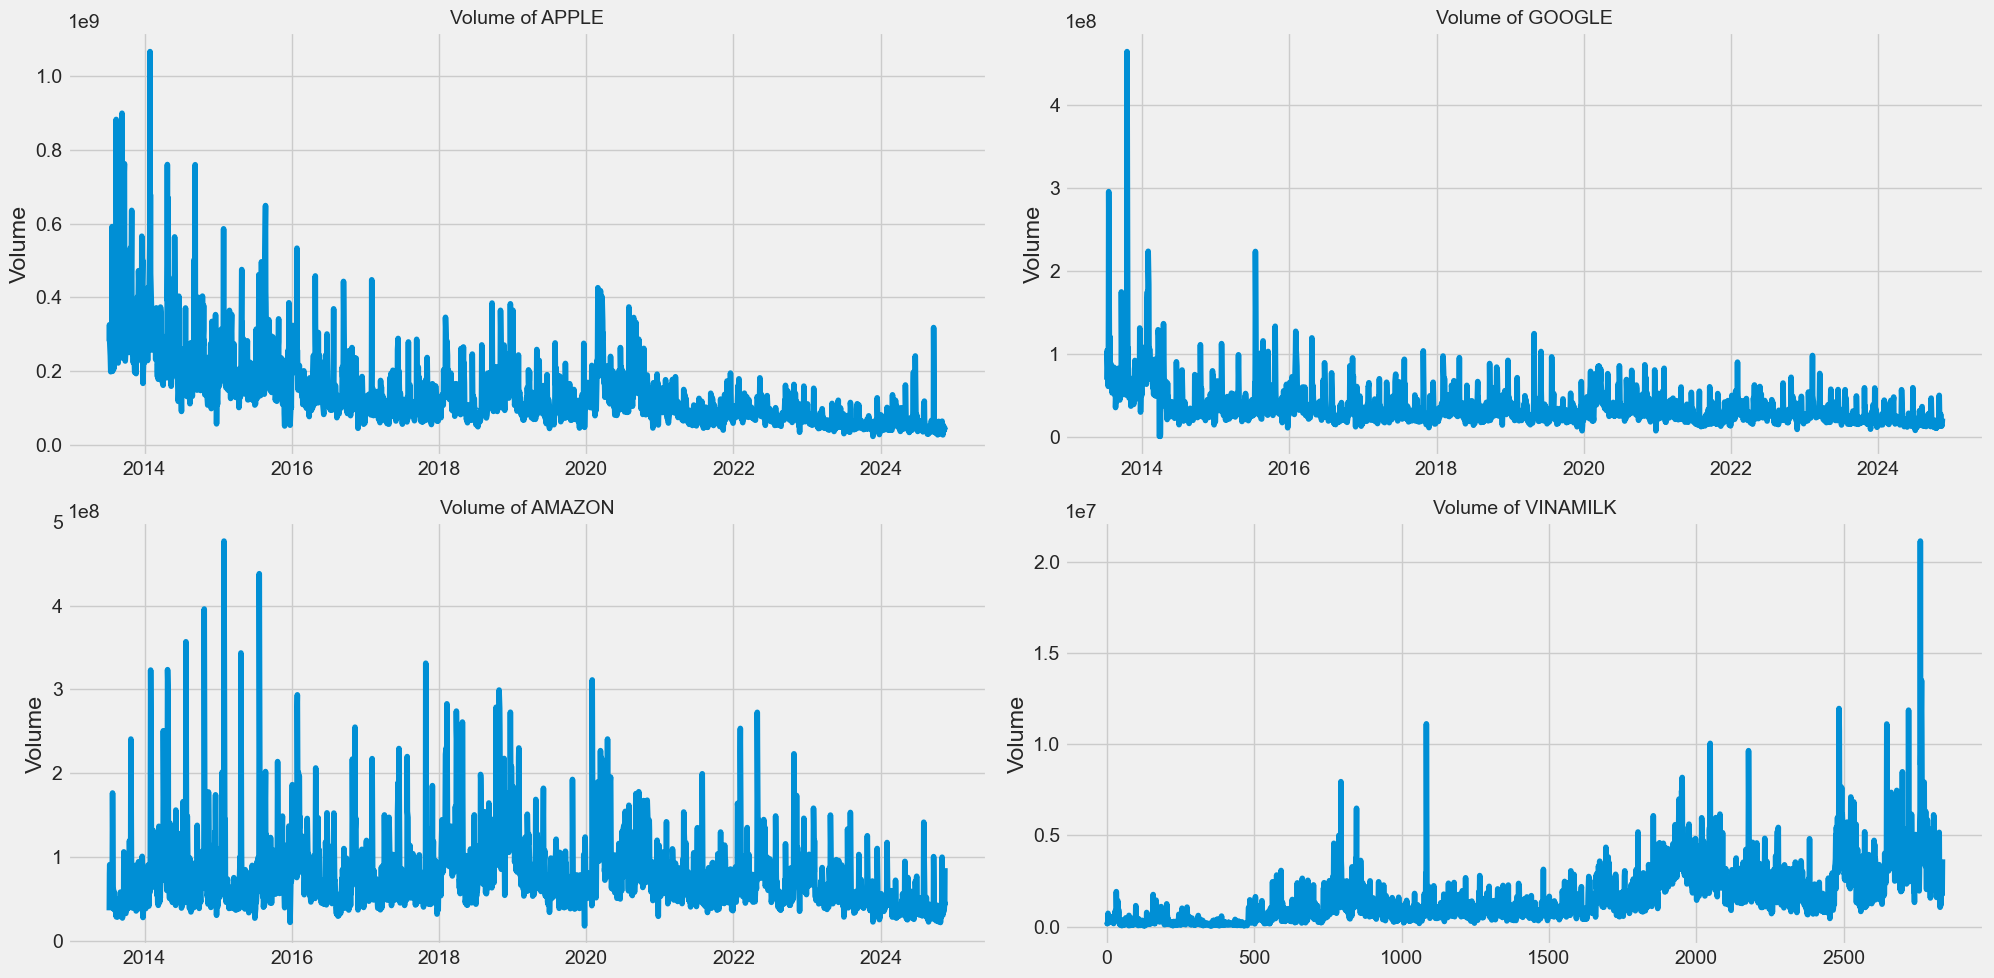

In [17]:
plt.figure(figsize = (20,10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, name in enumerate(company_list, 1):
    plt.subplot(rows,2,i)
    sns.lineplot(stock_data[name]['Volume'])
    plt.xlabel(None)
    plt.ylabel('Volume')
    plt.title(f"Volume of {name}", fontsize = 14)

plt.tight_layout()

### The chart shows the last 1000 days of "Adjusted Close" corrections along with two moving average trends (MA50 and MA200) for each company in the list
### MA lines help identify short-term and long-term trends of stock prices.

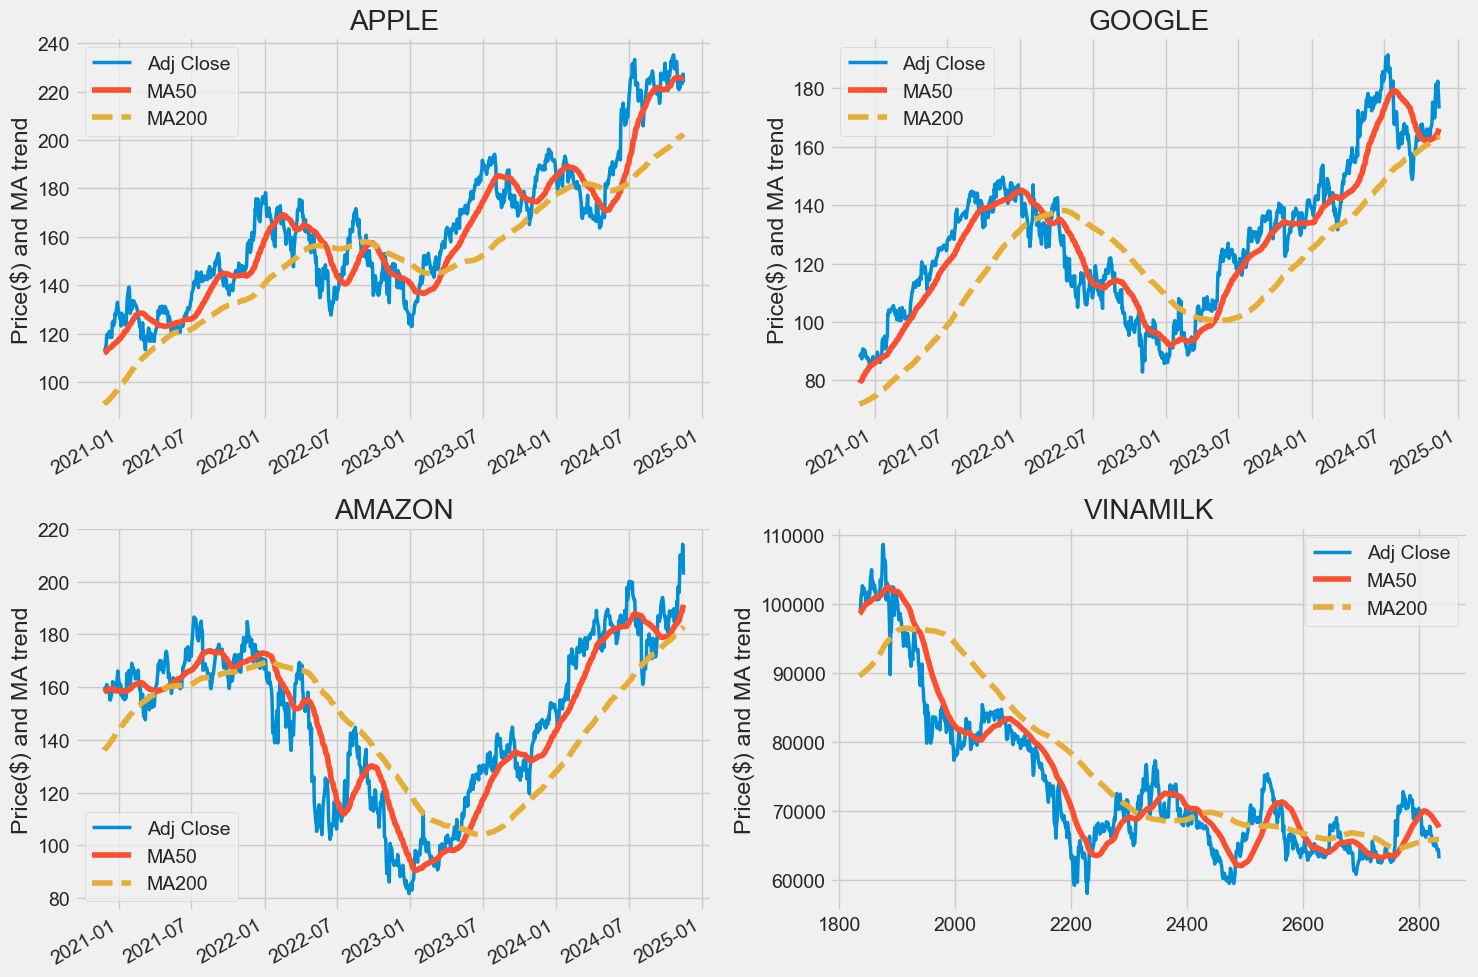

In [18]:
ma_day = [50, 200]

plt.figure(figsize = (15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, name in enumerate(company_list, 1):
    plt.subplot(rows, 2, i)
    stock_data[name]['Adj Close'][-1000:].plot(linewidth = 2.5)
    stock_data[name]['Adj Close'][-1000 - ma_day[0]:].rolling(ma_day[0]).mean().plot()
    stock_data[name]['Adj Close'][-1000 - ma_day[1]:].rolling(ma_day[1]).mean().plot(style = '--')
    plt.xlabel(None)
    plt.ylabel('Price($) and MA trend')
    plt.title(f'{name}')
    plt.legend(['Adj Close', 'MA50', 'MA200'])

plt.tight_layout()

# Prepare Apple Data

In [19]:
# Preprocessing for the data
raw_data = yf.download('AAPL', start=start_date, end=end_date, auto_adjust=False) # - Tải dữ liệu cổ phiếu AAPL từ Yahoo Finance từ `start_date` đến thời điểm hiện tại.

raw_data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # - Đặt lại tên cột của dữ liệu để đơn giản hóa.

df = raw_data[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] # - Chọn các cột cần thiết từ dữ liệu gốc để sử dụng.

data = df.filter(['Close']) # - Chỉ lấy cột "Close" (giá đóng cửa) từ dữ liệu, vì đây là cột cần phân tích.
dataset = data.values # - Chuyển dữ liệu "Close" thành một mảng numpy để dễ xử lý.
training_data_len = int(np.ceil( len(dataset) * .95 )) # - Xác định độ dài dữ liệu huấn luyện, tương ứng 95% tổng số dữ liệu.
pre_days = 90 # - Số ngày trước được sử dụng để dự đoán (ví dụ: dựa vào 90 ngày trước để dự đoán giá tiếp theo).


# Hàm preprocessing(df):
def preprocessing(df):
    # Scaler
    global scaler
    # MinMaxScaler:
    # - Chuẩn hóa dữ liệu về khoảng [0, 1] để đảm bảo tính ổn định cho các thuật toán học máy.
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    # Tạo tập huấn luyện
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []  # Danh sách để lưu các chuỗi giá trị đầu vào
    y_train = []  # Danh sách để lưu các giá trị đầu ra (mục tiêu)

    # Vòng lặp tạo tập huấn luyện
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])  # Lấy 60 giá trị trước làm đầu vào
        y_train.append(train_data[i, 0])      # Lấy giá trị thứ 61 làm đầu ra
        if i <= 61:
            # In ra giá trị đầu tiên để kiểm tra
            print(x_train)
            print(y_train)
            print()

    # Chuyển đổi x_train và y_train sang numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Định hình lại x_train để phù hợp với đầu vào của mô hình
    # (số mẫu, số bước thời gian, số đặc trưng)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tạo tập kiểm tra
    test_data = scaled_data[training_data_len - 60:, :]
    x_test = []  # Danh sách để lưu các chuỗi giá trị đầu vào
    y_test = dataset[training_data_len:, :]  # Giá trị thực tế để kiểm tra dự đoán

    # Vòng lặp tạo tập kiểm tra
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])  # Lấy 60 giá trị trước làm đầu vào

    # Chuyển đổi x_test sang numpy array
    x_test = np.array(x_test)

    # Định hình lại x_test để phù hợp với đầu vào của mô hình
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test

[*********************100%***********************]  1 of 1 completed


### Divide the data into 2 sets: train and test sets

In [20]:
# Gọi hàm preprocessing(AAPL) để tạo dữ liệu huấn luyện và kiểm tra cho cổ phiếu AAPL
AAPL_train_x, AAPL_train_y, AAPL_test_x, AAPL_test_y = preprocessing(AAPL)[0], preprocessing(AAPL)[1], preprocessing(AAPL)[2], preprocessing(AAPL)[3]

# Kiểm tra kích thước của các tập dữ liệu sau khi được xử lý
AAPL_train_x.shape, AAPL_train_y.shape, AAPL_test_x.shape, AAPL_test_y.shape

[array([0.00028053, 0.00133818, 0.00121242, 0.00136236, 0.00180735,
       0.00182508, 0.00205886, 0.00096091, 0.00118018, 0.        ,
       0.00346959, 0.00314553, 0.00354698, 0.00464333, 0.00553491,
       0.00540754, 0.00607663, 0.00702141, 0.00813549, 0.00745834,
       0.00741481, 0.00677474, 0.00571709, 0.00779853, 0.01137938,
       0.01281913, 0.012724  , 0.01343662, 0.01430886, 0.01323348,
       0.01344146, 0.01353819, 0.01322542, 0.01353981, 0.01122137,
       0.0115938 , 0.01172279, 0.01100049, 0.01121976, 0.01284975,
       0.01229836, 0.01277398, 0.01405573, 0.01219679, 0.00785496,
       0.00865787, 0.00740191, 0.00501898, 0.00585736, 0.00736644,
       0.00859499, 0.00780659, 0.01155189, 0.0113036 , 0.01008311,
       0.01083926, 0.01027981, 0.00931245, 0.0111198 , 0.01137776])]
[0.010386215207517119]

[array([0.00028053, 0.00133818, 0.00121242, 0.00136236, 0.00180735,
       0.00182508, 0.00205886, 0.00096091, 0.00118018, 0.        ,
       0.00346959, 0.00314553, 0.0

((2657, 60, 1), (2657,), (143, 60, 1), (143, 1))

# LSTM Model

# LSTM Apple model

In [ ]:
model_aapl = Sequential()
model_aapl.add(LSTM(128, return_sequences = True, input_shape = (AAPL_train_x.shape[1], 1)))
model_aapl.add(LSTM(64, return_sequences = True))
model_aapl.add(LSTM(32,  return_sequences = False))
model_aapl.add(Dropout(0.1))
model_aapl.add(Dense(62))
model_aapl.add(Dense(16))
model_aapl.add(Dense(1))

# Compile the model
model_aapl.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
save_model_lstm = "../../LOGS/LSTM+PSO/save_model_train_apples.keras"  # Lưu vào thư mục LOGS cùng cấp với MODEL
best_model_lstm = ModelCheckpoint(save_model_lstm, monitor='loss', verbose=2, save_best_only=True, mode='auto')
model_aapl.fit(AAPL_train_x, AAPL_train_y, epochs=20, batch_size=50, verbose=2, callbacks=[best_model_lstm])

Epoch 1/20

Epoch 1: loss improved from inf to 0.01042, saving model to ../../LOGS\save_model_train_apples.keras
54/54 - 7s - loss: 0.0104 - 7s/epoch - 133ms/step
Epoch 2/20

Epoch 2: loss improved from 0.01042 to 0.00135, saving model to ../../LOGS\save_model_train_apples.keras
54/54 - 4s - loss: 0.0013 - 4s/epoch - 78ms/step
Epoch 3/20

Epoch 3: loss improved from 0.00135 to 0.00110, saving model to ../../LOGS\save_model_train_apples.keras
54/54 - 4s - loss: 0.0011 - 4s/epoch - 75ms/step
Epoch 4/20

Epoch 4: loss improved from 0.00110 to 0.00099, saving model to ../../LOGS\save_model_train_apples.keras
54/54 - 3s - loss: 9.8974e-04 - 3s/epoch - 63ms/step
Epoch 5/20

Epoch 5: loss improved from 0.00099 to 0.00088, saving model to ../../LOGS\save_model_train_apples.keras
54/54 - 4s - loss: 8.8296e-04 - 4s/epoch - 67ms/step
Epoch 6/20

Epoch 6: loss improved from 0.00088 to 0.00086, saving model to ../../LOGS\save_model_train_apples.keras
54/54 - 4s - loss: 8.6194e-04 - 4s/epoch - 67ms/

# LSTM model combined with PSO

### Searching for optimal parameters with PSO

In [26]:
import json

# Hàm mục tiêu để tối ưu hóa tham số bằng PSO
def objective_function(params):
    params = params[0]  # Lấy bộ tham số đầu tiên
    n_neurons_1 = int(params[0])
    n_neurons_2 = int(params[1])
    n_neurons_3 = int(params[2])
    dropout_rate = params[3]
    batch_size = int(params[4])

    # Xây dựng mô hình LSTM
    model = Sequential([
        LSTM(n_neurons_1, return_sequences=True, input_shape=(AAPL_train_x.shape[1], 1)),
        LSTM(n_neurons_2, return_sequences=True),
        LSTM(n_neurons_3, return_sequences=False),
        Dropout(dropout_rate),
        Dense(62),
        Dense(16),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Huấn luyện mô hình
    model.fit(AAPL_train_x, AAPL_train_y, epochs=10, batch_size=batch_size, verbose=0)

    # Dự đoán và tính MSE
    predictions = model.predict(AAPL_test_x)
    mse = mean_squared_error(AAPL_test_y, predictions)

    return mse  # Trả về MSE để tối ưu hóa

# Cấu hình tham số PSO
bounds = ([32, 32, 32, 0.1, 20], [128, 128, 128, 0.5, 64])

# Chạy thuật toán tối ưu hóa PSO
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, bounds=bounds)
best_cost, best_params = optimizer.optimize(objective_function, iters=5)

# Lưu tham số tối ưu vào tệp JSON
best_params_dict = {
    "n_neurons_1": int(best_params[0]),
    "n_neurons_2": int(best_params[1]),
    "n_neurons_3": int(best_params[2]),
    "dropout_rate": best_params[3],
    "batch_size": int(best_params[4])
}

2025-12-14 17:24:49,115 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/5

5/5 [==============================] - 1s 21ms/step


pyswarms.single.global_best:  20%|██        |1/5, best_cost=4.62e+4

5/5 [==============================] - 1s 21ms/step


pyswarms.single.global_best:  40%|████      |2/5, best_cost=4.62e+4

5/5 [==============================] - 1s 34ms/step


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=4.62e+4

5/5 [==============================] - 1s 26ms/step


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=4.62e+4

5/5 [==============================] - 1s 24ms/step


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=4.62e+4
2025-12-14 17:28:18,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46173.75755239907, best pos: [98.78437339 36.7004137  84.74649053  0.29724693 58.42332165]


### Use optimal parameters to train the LSTM model

In [ ]:
# Huấn luyện mô hình với tham số tối ưu
final_model = Sequential([
    LSTM(best_params_dict["n_neurons_1"], return_sequences=True, input_shape=(AAPL_train_x.shape[1], 1)),
    LSTM(best_params_dict["n_neurons_2"], return_sequences=True),
    LSTM(best_params_dict["n_neurons_3"], return_sequences=False),
    Dropout(best_params_dict["dropout_rate"]),
    Dense(62),
    Dense(16),
    Dense(1)
])
final_model.compile(optimizer='adam', loss='mean_squared_error')

# Lưu mô hình tốt nhất
save_model = "../../LOGS/LSTM+PSO/save_model_train_apple_bests.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện với batch_size tối ưu
final_model.fit(AAPL_train_x, AAPL_train_y, epochs=10, batch_size=best_params_dict["batch_size"], verbose=2, callbacks=[best_model])

Epoch 1/10

Epoch 1: loss improved from inf to 0.01047, saving model to ../../LOGS\save_model_train_apple_bests.keras
46/46 - 7s - loss: 0.0105 - 7s/epoch - 155ms/step
Epoch 2/10

Epoch 2: loss improved from 0.01047 to 0.00162, saving model to ../../LOGS\save_model_train_apple_bests.keras
46/46 - 4s - loss: 0.0016 - 4s/epoch - 83ms/step
Epoch 3/10

Epoch 3: loss improved from 0.00162 to 0.00132, saving model to ../../LOGS\save_model_train_apple_bests.keras
46/46 - 4s - loss: 0.0013 - 4s/epoch - 86ms/step
Epoch 4/10

Epoch 4: loss improved from 0.00132 to 0.00115, saving model to ../../LOGS\save_model_train_apple_bests.keras
46/46 - 4s - loss: 0.0011 - 4s/epoch - 95ms/step
Epoch 5/10

Epoch 5: loss improved from 0.00115 to 0.00104, saving model to ../../LOGS\save_model_train_apple_bests.keras
46/46 - 5s - loss: 0.0010 - 5s/epoch - 102ms/step
Epoch 6/10

Epoch 6: loss improved from 0.00104 to 0.00089, saving model to ../../LOGS\save_model_train_apple_bests.keras
46/46 - 4s - loss: 8.9472

# Prepare Amazon Data

In [33]:
raw_data_amz = yf.download('AMZN', start=start_date, end=end_date, auto_adjust=False) # - Tải dữ liệu cổ phiếu AMZN từ Yahoo Finance từ `start_date` đến thời điểm hiện tại.

raw_data_amz.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # - Đặt lại tên cột của dữ liệu để đơn giản hóa.

df_amz = raw_data_amz[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] # - Chọn các cột cần thiết từ dữ liệu gốc để sử dụng.

data_amz = df_amz.filter(['Close']) # - Chỉ lấy cột "Close" (giá đóng cửa) từ dữ liệu, vì đây là cột cần phân tích.
dataset_amz = data_amz.values # - Chuyển dữ liệu "Close" thành một mảng numpy để dễ xử lý.
training_data_len_amz = int(np.ceil( len(dataset_amz) * .95 )) # - Xác định độ dài dữ liệu huấn luyện, tương ứng 95% tổng số dữ liệu.
pre_days = 90 # - Số ngày trước được sử dụng để dự đoán (ví dụ: dựa vào 90 ngày trước để dự đoán giá tiếp theo).

def preprocessing_amz(df_amz):
    # Scaler
    global scaler_amz

    # MinMaxScaler:
    # - Chuẩn hóa dữ liệu về khoảng [0, 1] để đảm bảo tính ổn định cho các thuật toán học máy.
    scaler_amz = MinMaxScaler(feature_range=(0,1))
    scaled_data_amz = scaler_amz.fit_transform(dataset_amz)

    # Tạo tập huấn luyện
    train_data_amz = scaled_data_amz[0:int(training_data_len_amz), :]
    x_train = [] # Danh sách để lưu các chuỗi giá trị đầu vào
    y_train = [] # Danh sách để lưu các giá trị đầu ra (mục tiêu)

    for i in range(90, len(train_data_amz)):
        x_train.append(train_data_amz[i-90:i, 0]) # Lấy 90 giá trị trước làm đầu vào
        y_train.append(train_data_amz[i, 0])      # Lấy giá trị thứ 61 làm đầu ra
        if i<= 91:
            # In ra giá trị đầu tiên để kiểm tra
            print(x_train)
            print(y_train)
            print()

    # Chuyển đổi x_train và y_train sang numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Định hình lại x_train để phù hợp với đầu vào của mô hình
    # (số mẫu, số bước thời gian, số đặc trưng)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tạo tập kiểm tra
    test_data_amz = scaled_data_amz[training_data_len_amz - 90: , :]
    x_test = [] # Danh sách để lưu các chuỗi giá trị đầu vào
    y_test = dataset_amz[training_data_len_amz:, :] # Giá trị thực tế để kiểm tra dự đoán

    # Vòng lặp tạo tập kiểm tra
    for i in range(90, len(test_data_amz)):
        x_test.append(test_data_amz[i-90:i, 0]) # Lấy 90 giá trị trước làm đầu vào

    # Chuyển đổi x_test sang numpy array
    x_test = np.array(x_test)

    # Định hình lại x_test để phù hợp với đầu vào của mô hình
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    return x_train, y_train, x_test, y_test

[*********************100%***********************]  1 of 1 completed


### Divide the data into 2 sets: train and test sets

In [34]:
# Gọi hàm preprocessing(AMZN) để tạo dữ liệu huấn luyện và kiểm tra cho cổ phiếu AMZN
AMZN_train_x, AMZN_train_y, AMZN_test_x, AMZN_test_y = preprocessing_amz(AMZN)[0], preprocessing_amz(AMZN)[1], preprocessing_amz(AMZN)[2], preprocessing_amz(AMZN)[3]

# Kiểm tra kích thước của các tập dữ liệu sau khi được xử lý
AMZN_train_x.shape, AMZN_train_y.shape, AMZN_test_x.shape, AMZN_test_y.shape

[array([2.84923622e-03, 4.68124561e-03, 6.65321694e-03, 6.40828354e-03,
       6.48326519e-03, 6.93814152e-03, 5.79344730e-03, 6.07337596e-03,
       5.63599011e-03, 5.03115524e-03, 4.50129249e-03, 5.61599691e-03,
       7.76792136e-03, 6.29081752e-03, 5.36856078e-03, 5.07114164e-03,
       6.15834945e-03, 5.81844118e-03, 5.01366000e-03, 4.95367562e-03,
       3.99393044e-03, 3.70150722e-03, 4.08140665e-03, 3.93894675e-03,
       3.25912546e-03, 2.60180486e-03, 1.38462694e-03, 9.72239745e-04,
       1.15968674e-03, 1.53958617e-03, 9.09757414e-04, 2.19940950e-03,
       2.26939047e-03, 1.31964665e-03, 0.00000000e+00, 1.62457873e-04,
       7.62296826e-04, 1.24945593e-05, 1.96697065e-03, 3.17664992e-03,
       3.29161798e-03, 3.73150179e-03, 4.69374493e-03, 4.85619804e-03,
       4.67624969e-03, 4.48129929e-03, 4.24636249e-03, 3.78148956e-03,
       5.80844458e-03, 7.77291727e-03, 7.78041592e-03, 8.85013324e-03,
       7.63795601e-03, 8.29777934e-03, 7.92787650e-03, 9.29501297e-03,
     

((2627, 90, 1), (2627,), (143, 90, 1), (143, 1))

# LSTM Model

# LSTM Amazon Model

In [35]:
# Build the LSTM model
model_amz = Sequential()
model_amz.add(LSTM(128, return_sequences = True, input_shape = (AMZN_train_x.shape[1], 1)))
model_amz.add(LSTM(64, return_sequences = True))
model_amz.add(LSTM(32, return_sequences = False))
model_amz.add(Dropout(0.1))
model_amz.add(Dense(62))
model_amz.add(Dense(16))
model_amz.add(Dense(1))

# Compile the model
model_amz.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
save_model_amz_lstm = "../../LOGS/LSTM+PSO/save_model_train_amazons.keras"
best_model_amz_lstm = ModelCheckpoint(save_model_amz_lstm,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model_amz.fit(AMZN_train_x,AMZN_train_y,epochs=20,batch_size=50,verbose=2,callbacks=[best_model_amz_lstm])

Epoch 1/20

Epoch 1: loss improved from inf to 0.01650, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazons.keras
53/53 - 8s - loss: 0.0165 - 8s/epoch - 158ms/step
Epoch 2/20

Epoch 2: loss improved from 0.01650 to 0.00157, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazons.keras
53/53 - 6s - loss: 0.0016 - 6s/epoch - 107ms/step
Epoch 3/20

Epoch 3: loss improved from 0.00157 to 0.00141, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazons.keras
53/53 - 6s - loss: 0.0014 - 6s/epoch - 106ms/step
Epoch 4/20

Epoch 4: loss improved from 0.00141 to 0.00125, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazons.keras
53/53 - 6s - loss: 0.0012 - 6s/epoch - 108ms/step
Epoch 5/20

Epoch 5: loss did not improve from 0.00125
53/53 - 6s - loss: 0.0013 - 6s/epoch - 116ms/step
Epoch 6/20

Epoch 6: loss improved from 0.00125 to 0.00116, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazons.keras
53/53 - 6s - loss: 0.0012 - 6s/epoch - 119ms/step
Epoch 7/20

Ep

# LSTM model combined with PSO

### Searching for optimal parameters with PSO

In [36]:
# Hàm mục tiêu để tối ưu hóa tham số bằng PSO
def objective_function_amz(params):
    params = params[0]  # Lấy bộ tham số đầu tiên
    n_neurons_1 = int(params[0])
    n_neurons_2 = int(params[1])
    n_neurons_3 = int(params[2])
    dropout_rate = params[3]
    batch_size = int(params[4])

    # Xây dựng mô hình LSTM
    model = Sequential([
        LSTM(n_neurons_1, return_sequences=True, input_shape=(AMZN_train_x.shape[1], 1)),
        LSTM(n_neurons_2, return_sequences=True),
        LSTM(n_neurons_3, return_sequences=False),
        Dropout(dropout_rate),
        Dense(62),
        Dense(16),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Huấn luyện mô hình
    model.fit(AMZN_train_x, AMZN_train_y, epochs=10, batch_size=batch_size, verbose=0)

    # Dự đoán và tính MSE
    predictions_amz = model.predict(AMZN_test_x)
    mse = mean_squared_error(AMZN_test_y, predictions_amz)

    return mse  # Trả về MSE để tối ưu hóa

# Cấu hình tham số PSO
bounds = ([32, 32, 32, 0.1, 20], [128, 128, 128, 0.5, 64])

# Chạy thuật toán tối ưu hóa PSO
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, bounds=bounds)
best_cost_amz, best_params_amz = optimizer.optimize(objective_function_amz, iters=5)

# Lưu tham số tối ưu vào tệp JSON
best_params_amz_dict = {
    "n_neurons_1": int(best_params_amz[0]),
    "n_neurons_2": int(best_params_amz[1]),
    "n_neurons_3": int(best_params_amz[2]),
    "dropout_rate": best_params_amz[3],
    "batch_size": int(best_params_amz[4])
}

2025-12-14 17:44:07,686 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/5

5/5 [==============================] - 1s 35ms/step


pyswarms.single.global_best:  20%|██        |1/5, best_cost=3.42e+4

5/5 [==============================] - 1s 33ms/step


pyswarms.single.global_best:  40%|████      |2/5, best_cost=3.42e+4

5/5 [==============================] - 1s 33ms/step


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=3.42e+4

5/5 [==============================] - 1s 41ms/step


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=3.42e+4

5/5 [==============================] - 1s 36ms/step


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=3.42e+4
2025-12-14 17:53:13,148 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34207.219039381285, best pos: [69.94793475 75.03879487 55.50863294  0.11286468 25.31009216]


### Use optimal parameters to train the LSTM model

In [38]:
# Huấn luyện mô hình với tham số tối ưu
final_model_amz = Sequential([
    LSTM(best_params_amz_dict["n_neurons_1"], return_sequences=True, input_shape=(AMZN_train_x.shape[1], 1)),
    LSTM(best_params_amz_dict["n_neurons_2"], return_sequences=True),
    LSTM(best_params_amz_dict["n_neurons_3"], return_sequences=False),
    Dropout(best_params_amz_dict["dropout_rate"]),
    Dense(62),
    Dense(16),
    Dense(1)
])
final_model_amz.compile(optimizer='adam', loss='mean_squared_error')

# Lưu mô hình tốt nhất
save_model_amz = "../../LOGS/LSTM+PSO/save_model_train_amazon_bests.keras"
best_model_amz = ModelCheckpoint(save_model_amz, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện với batch_size tối ưu
final_model_amz.fit(AMZN_train_x, AMZN_train_y, epochs=10, batch_size=best_params_amz_dict["batch_size"], verbose=2, callbacks=[best_model_amz])

Epoch 1/10

Epoch 1: loss improved from inf to 0.00799, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazon_bests.keras
106/106 - 14s - loss: 0.0080 - 14s/epoch - 135ms/step
Epoch 2/10

Epoch 2: loss improved from 0.00799 to 0.00154, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazon_bests.keras
106/106 - 12s - loss: 0.0015 - 12s/epoch - 109ms/step
Epoch 3/10

Epoch 3: loss improved from 0.00154 to 0.00126, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazon_bests.keras
106/106 - 12s - loss: 0.0013 - 12s/epoch - 113ms/step
Epoch 4/10

Epoch 4: loss improved from 0.00126 to 0.00121, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazon_bests.keras
106/106 - 11s - loss: 0.0012 - 11s/epoch - 100ms/step
Epoch 5/10

Epoch 5: loss improved from 0.00121 to 0.00101, saving model to ../../LOGS/LSTM+PSO\save_model_train_amazon_bests.keras
106/106 - 10s - loss: 0.0010 - 10s/epoch - 98ms/step
Epoch 6/10

Epoch 6: loss improved from 0.00101 to 0.00080, saving model to

# Prepare Google Data

In [39]:
raw_data_gg = yf.download('GOOG', start=start_date, end=end_date, auto_adjust=False) # - Tải dữ liệu cổ phiếu GOOG từ Yahoo Finance từ `start_date` đến thời điểm hiện tại.

raw_data_gg.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'] # - Đặt lại tên cột của dữ liệu để đơn giản hóa.

df_gg = raw_data_gg[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']] # - Chọn các cột cần thiết từ dữ liệu gốc để sử dụng.

data_gg = df_gg.filter(['Close']) # - Chỉ lấy cột "Close" (giá đóng cửa) từ dữ liệu, vì đây là cột cần phân tích.
dataset_gg = data_gg.values # - Chuyển dữ liệu "Close" thành một mảng numpy để dễ xử lý.
training_data_len_gg = int(np.ceil( len(dataset_gg) * .95 )) # - Xác định độ dài dữ liệu huấn luyện, tương ứng 95% tổng số dữ liệu.
pre_days = 90 # - Số ngày trước được sử dụng để dự đoán (ví dụ: dựa vào 90 ngày trước để dự đoán giá tiếp theo).

def preprocessing_gg(df_gg):
    # Scaler
    global scaler_gg

    # MinMaxScaler:
    # - Chuẩn hóa dữ liệu về khoảng [0, 1] để đảm bảo tính ổn định cho các thuật toán học máy.
    scaler_gg = MinMaxScaler(feature_range=(0,1))
    scaled_data_gg = scaler_gg.fit_transform(dataset_gg)

    # Tạo tập huấn luyện
    train_data_gg = scaled_data_gg[0:int(training_data_len_gg), :]
    # Split the data into x_train and y_train data sets
    x_train = [] # Danh sách để lưu các giá trị đầu ra (mục tiêu)
    y_train = [] # Danh sách để lưu các chuỗi giá trị đầu vào

    for i in range(90, len(train_data_gg)):
        x_train.append(train_data_gg[i-90:i, 0]) # Lấy 90 giá trị trước làm đầu vào
        y_train.append(train_data_gg[i, 0])      # Lấy giá trị thứ 61 làm đầu ra
        if i<= 91:
            # In ra giá trị đầu tiên để kiểm tra
            print(x_train)
            print(y_train)
            print()

    # Chuyển đổi x_train và y_train sang numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Định hình lại x_train để phù hợp với đầu vào của mô hình
    # (số mẫu, số bước thời gian, số đặc trưng)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    # Tạo tập kiểm tra
    test_data_gg = scaled_data_gg[training_data_len_gg - 90: , :]

    x_test = []  # Danh sách để lưu các chuỗi giá trị đầu vào
    y_test = dataset_gg[training_data_len_gg:, :]  # Giá trị thực tế để kiểm tra dự đoán

    # Vòng lặp tạo tập kiểm tra
    for i in range(90, len(test_data_gg)):
        x_test.append(test_data_gg[i-90:i, 0])  # Lấy 90 giá trị trước làm đầu vào

    # Chuyển đổi x_test sang numpy array
    x_test = np.array(x_test)

    # Định hình lại x_test để phù hợp với đầu vào của mô hình
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

    return x_train, y_train, x_test, y_test

[*********************100%***********************]  1 of 1 completed


### Divide the data into 2 sets: train and test sets

In [40]:
# Gọi hàm preprocessing(GOOG) để tạo dữ liệu huấn luyện và kiểm tra cho cổ phiếu GOOG
GOOG_train_x, GOOG_train_y, GOOG_test_x, GOOG_test_y = preprocessing_gg(GOOG)[0], preprocessing_gg(GOOG)[1], preprocessing_gg(GOOG)[2], preprocessing_gg(GOOG)[3]

# Kiểm tra kích thước của các tập dữ liệu sau khi được xử lý
GOOG_train_x.shape, GOOG_train_y.shape, GOOG_test_x.shape, GOOG_test_y.shape

[array([0.0085782 , 0.0106469 , 0.01104758, 0.01129291, 0.01055545,
       0.01040157, 0.00925906, 0.00721504, 0.00926196, 0.00826028,
       0.00812962, 0.00592302, 0.00558186, 0.00513472, 0.00639046,
       0.00593026, 0.00832125, 0.00866241, 0.00843448, 0.00721068,
       0.00635126, 0.00664307, 0.00631643, 0.00560508, 0.00498665,
       0.00332588, 0.00185239, 0.00145317, 0.00272197, 0.00268858,
       0.00325621, 0.00389206, 0.00338395, 0.0028294 , 0.00047181,
       0.00023953, 0.00123831, 0.        , 0.00195691, 0.00359009,
       0.00474131, 0.00474422, 0.00597382, 0.00606383, 0.00715552,
       0.00670113, 0.00612189, 0.00593172, 0.00569219, 0.00819059,
       0.0074749 , 0.00816011, 0.00574881, 0.00579816, 0.00440305,
       0.00453952, 0.00428112, 0.00421143, 0.00582139, 0.00596512,
       0.00423756, 0.00369462, 0.00273503, 0.00098281, 0.00130074,
       0.00309797, 0.00364236, 0.00424046, 0.00509698, 0.00742263,
       0.00608125, 0.02388222, 0.02270488, 0.02324201, 0.0267

((2627, 90, 1), (2627,), (143, 90, 1), (143, 1))

# LSTM Model

In [42]:
# # Build the LSTM model
model_gg = Sequential()
model_gg.add(LSTM(128, return_sequences = True, input_shape = (GOOG_train_x.shape[1], 1)))
model_gg.add(LSTM(64, return_sequences = True))
model_gg.add(LSTM(32, return_sequences = False))
model_gg.add(Dropout(0.1))
model_gg.add(Dense(62))
model_gg.add(Dense(16))
model_gg.add(Dense(1))

model_gg.compile(loss='mean_squared_error', optimizer='Adam')

# Train the model
save_model_gg = "../../LOGS/LSTM+PSO/save_model_train_googles.keras"
best_model_gg = ModelCheckpoint(save_model_gg,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model_gg.fit(GOOG_train_x,GOOG_train_y,epochs=10,batch_size=50,verbose=2,callbacks=[best_model_gg])

Epoch 1/10

Epoch 1: loss improved from inf to 0.01174, saving model to ../../LOGS/LSTM+PSO\save_model_train_googles.keras
53/53 - 11s - loss: 0.0117 - 11s/epoch - 200ms/step
Epoch 2/10

Epoch 2: loss improved from 0.01174 to 0.00107, saving model to ../../LOGS/LSTM+PSO\save_model_train_googles.keras
53/53 - 7s - loss: 0.0011 - 7s/epoch - 131ms/step
Epoch 3/10

Epoch 3: loss improved from 0.00107 to 0.00103, saving model to ../../LOGS/LSTM+PSO\save_model_train_googles.keras
53/53 - 6s - loss: 0.0010 - 6s/epoch - 113ms/step
Epoch 4/10

Epoch 4: loss improved from 0.00103 to 0.00092, saving model to ../../LOGS/LSTM+PSO\save_model_train_googles.keras
53/53 - 6s - loss: 9.1965e-04 - 6s/epoch - 113ms/step
Epoch 5/10

Epoch 5: loss improved from 0.00092 to 0.00090, saving model to ../../LOGS/LSTM+PSO\save_model_train_googles.keras
53/53 - 6s - loss: 8.9568e-04 - 6s/epoch - 115ms/step
Epoch 6/10

Epoch 6: loss improved from 0.00090 to 0.00074, saving model to ../../LOGS/LSTM+PSO\save_model_tr

# LSTM model combined with PSO

### Searching for optimal parameters with PSO

In [44]:
# Hàm mục tiêu để tối ưu hóa tham số bằng PSO
def objective_function_gg(params):
    params = params[0]  # Lấy bộ tham số đầu tiên
    n_neurons_1 = int(params[0])
    n_neurons_2 = int(params[1])
    n_neurons_3 = int(params[2])
    dropout_rate = params[3]
    batch_size = int(params[4])

    # Xây dựng mô hình LSTM
    model = Sequential([
        LSTM(n_neurons_1, return_sequences=True, input_shape=(GOOG_train_x.shape[1], 1)),
        LSTM(n_neurons_2, return_sequences=True),
        LSTM(n_neurons_3, return_sequences=False),
        Dropout(dropout_rate),
        Dense(62),
        Dense(16),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Huấn luyện mô hình
    model.fit(GOOG_train_x, GOOG_train_y, epochs=10, batch_size=batch_size, verbose=0)

    # Dự đoán và tính MSE
    predictions_gg = model.predict(GOOG_test_x)
    mse = mean_squared_error(GOOG_test_y, predictions_gg)

    return mse  # Trả về MSE để tối ưu hóa

# Cấu hình tham số PSO
bounds = ([32, 32, 32, 0.1, 20], [128, 128, 128, 0.5, 64])

# Chạy thuật toán tối ưu hóa PSO
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, bounds=bounds)
best_cost_gg, best_params_gg = optimizer.optimize(objective_function_gg, iters=5)

# Lưu tham số tối ưu vào tệp JSON
best_params_gg_dict = {
    "n_neurons_1": int(best_params_gg[0]),
    "n_neurons_2": int(best_params_gg[1]),
    "n_neurons_3": int(best_params_gg[2]),
    "dropout_rate": best_params_gg[3],
    "batch_size": int(best_params_gg[4])
}

2025-12-14 21:21:03,759 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/5

5/5 [==============================] - 1s 61ms/step


pyswarms.single.global_best:  20%|██        |1/5, best_cost=2.92e+4

5/5 [==============================] - 1s 61ms/step


pyswarms.single.global_best:  40%|████      |2/5, best_cost=2.92e+4

5/5 [==============================] - 1s 63ms/step


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=2.92e+4

5/5 [==============================] - 1s 66ms/step


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=2.92e+4

5/5 [==============================] - 1s 62ms/step


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=2.92e+4
2025-12-14 21:35:15,408 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 29159.029084580656, best pos: [ 56.13796005 116.320326   125.82831637   0.43000561  20.02613222]


###  Use optimal parameters to train the LSTM model

In [45]:
# Huấn luyện mô hình với tham số tối ưu
final_model_gg = Sequential([
    LSTM(best_params_gg_dict["n_neurons_1"], return_sequences=True, input_shape=(GOOG_train_x.shape[1], 1)),
    LSTM(best_params_gg_dict["n_neurons_2"], return_sequences=True),
    LSTM(best_params_gg_dict["n_neurons_3"], return_sequences=False),
    Dropout(best_params_gg_dict["dropout_rate"]),
    Dense(62),
    Dense(16),
    Dense(1)
])
final_model_gg.compile(optimizer='adam', loss='mean_squared_error')

# Lưu mô hình tốt nhất
save_model_gg = ".../../LOGS/LSTM+PSO/save_model_train_google_bests.keras"
best_model_gg = ModelCheckpoint(save_model_gg, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện với batch_size tối ưu
final_model_gg.fit(GOOG_train_x, GOOG_train_y, epochs=10, batch_size=best_params_gg_dict["batch_size"], verbose=2, callbacks=[best_model_gg])

Epoch 1/10

Epoch 1: loss improved from inf to 0.00428, saving model to .../../LOGS/LSTM+PSO\save_model_train_google_bests.keras
132/132 - 21s - loss: 0.0043 - 21s/epoch - 157ms/step
Epoch 2/10

Epoch 2: loss improved from 0.00428 to 0.00136, saving model to .../../LOGS/LSTM+PSO\save_model_train_google_bests.keras
132/132 - 25s - loss: 0.0014 - 25s/epoch - 187ms/step
Epoch 3/10

Epoch 3: loss did not improve from 0.00136
132/132 - 24s - loss: 0.0015 - 24s/epoch - 183ms/step
Epoch 4/10

Epoch 4: loss improved from 0.00136 to 0.00095, saving model to .../../LOGS/LSTM+PSO\save_model_train_google_bests.keras
132/132 - 23s - loss: 9.5236e-04 - 23s/epoch - 174ms/step
Epoch 5/10

Epoch 5: loss improved from 0.00095 to 0.00087, saving model to .../../LOGS/LSTM+PSO\save_model_train_google_bests.keras
132/132 - 24s - loss: 8.7013e-04 - 24s/epoch - 181ms/step
Epoch 6/10

Epoch 6: loss did not improve from 0.00087
132/132 - 23s - loss: 0.0010 - 23s/epoch - 172ms/step
Epoch 7/10

Epoch 7: loss impr

# LSTM Vinamilk Model

# Prepare Vinamilk Data

### Divide the data into 2 sets: train and test sets

In [46]:
# Preprocessing for the data
raw_data = df_vnm.copy() # - Tạo một bản sao của dữ liệu gốc để tránh thay đổi dữ liệu gốc trong quá trình xử lý.

df_vnm = raw_data[['Close', 'Open', 'High', 'Low', 'Volume', 'Adj Close']] # - Chọn các cột cần thiết từ dữ liệu gốc để sử dụng.

data_vnm = df_vnm.filter(['Close']) # - Chỉ lấy cột "Close" (giá đóng cửa) từ dữ liệu, vì đây là cột cần phân tích.
dataset_vnm = data_vnm.values # - Chuyển dữ liệu "Close" thành một mảng numpy để dễ xử lý.
training_data_len_vnm = int(np.ceil( len(dataset_vnm) * .95 )) # - Xác định độ dài dữ liệu huấn luyện, tương ứng 95% tổng số dữ liệu.
pre_days = 90 # - Số ngày trước được sử dụng để dự đoán (ví dụ: dựa vào 90 ngày trước để dự đoán giá tiếp theo).

# Hàm preprocessing(df):
def preprocessing_vnm(df_vnm):
    # Scaler
    global scaler_vnm
    # MinMaxScaler:
    # - Chuẩn hóa dữ liệu về khoảng [0, 1] để đảm bảo tính ổn định cho các thuật toán học máy.
    scaler_vnm = MinMaxScaler(feature_range=(0, 1))
    scaled_data_vnm = scaler_vnm.fit_transform(dataset_vnm)

    # Tạo tập huấn luyện
    train_data = scaled_data_vnm[0:int(training_data_len_vnm), :]
    x_train = []  # Danh sách để lưu các chuỗi giá trị đầu vào
    y_train = []  # Danh sách để lưu các giá trị đầu ra (mục tiêu)

    # Vòng lặp tạo tập huấn luyện
    for i in range(90, len(train_data)):
        x_train.append(train_data[i-90:i, 0])  # Lấy 90 giá trị trước làm đầu vào
        y_train.append(train_data[i, 0])      # Lấy giá trị thứ 61 làm đầu ra
        if i <= 91:
            # In ra giá trị đầu tiên để kiểm tra
            print(x_train)
            print(y_train)
            print()

    # Chuyển đổi x_train và y_train sang numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Định hình lại x_train để phù hợp với đầu vào của mô hình
    # (số mẫu, số bước thời gian, số đặc trưng)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Tạo tập kiểm tra
    test_data = scaled_data_vnm[training_data_len_vnm - 90:, :]
    x_test = []  # Danh sách để lưu các chuỗi giá trị đầu vào
    y_test = dataset_vnm[training_data_len_vnm:, :]  # Giá trị thực tế để kiểm tra dự đoán

    # Vòng lặp tạo tập kiểm tra
    for i in range(90, len(test_data)):
        x_test.append(test_data[i-90:i, 0])  # Lấy 90 giá trị trước làm đầu vào

    # Chuyển đổi x_test sang numpy array
    x_test = np.array(x_test)

    # Định hình lại x_test để phù hợp với đầu vào của mô hình
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test

In [47]:
# Gọi hàm preprocessing_vnm(df_vnm) để tạo dữ liệu huấn luyện và kiểm tra cho cổ phiếu VNM
VNM_train_x, VNM_train_y, VNM_test_x, VNM_test_y = preprocessing_vnm(df)[0], preprocessing_vnm(df)[1], preprocessing_vnm(df)[2], preprocessing_vnm(df)[3]

# Kiểm tra kích thước của các tập dữ liệu sau khi được xử lý
VNM_train_x.shape, VNM_train_y.shape, VNM_test_x.shape, VNM_test_y.shape

[array([0.30927861, 0.30927861, 0.31519538, 0.31519538, 0.32702041,
       0.33292867, 0.33292867, 0.35657873, 0.36248699, 0.36248699,
       0.3447537 , 0.35066195, 0.35657873, 0.33884544, 0.3447537 ,
       0.36248699, 0.36248699, 0.36840376, 0.35657873, 0.36840376,
       0.36248699, 0.36248699, 0.36248699, 0.36248699, 0.37431202,
       0.38613705, 0.39796208, 0.39205382, 0.39205382, 0.36840376,
       0.36840376, 0.35066195, 0.30927861, 0.33292867, 0.32702041,
       0.29154532, 0.28563706, 0.27381203, 0.29154532, 0.30927861,
       0.32702041, 0.32702041, 0.30927861, 0.32110364, 0.32110364,
       0.31519538, 0.32110364, 0.31519538, 0.31519538, 0.30927861,
       0.31519538, 0.32110364, 0.31519538, 0.32110364, 0.33292867,
       0.32702041, 0.33292867, 0.33884544, 0.32702041, 0.33292867,
       0.32702041, 0.33292867, 0.33292867, 0.33292867, 0.3447537 ,
       0.33292867, 0.33292867, 0.33884544, 0.3447537 , 0.3447537 ,
       0.33884544, 0.3447537 , 0.3447537 , 0.33884544, 0.3388

((2605, 90, 1), (2605,), (141, 90, 1), (141, 1))

In [48]:
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
#2 lớp LSTM
model.add(LSTM(units=128,input_shape=(VNM_train_x.shape[1],1),return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.1)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(62))
model.add(Dense(16))
model.add(Dense(1)) #output đầu ra 1 chiều
#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
#huấn luyện mô hình
save_model_vnm_lstm = "../../LOGS/LSTM+PSO/save_model_vnms.keras"
best_model_vnm_lstm = ModelCheckpoint(save_model_vnm_lstm,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(VNM_train_x,VNM_train_y,epochs=10,batch_size=50,verbose=2,callbacks=[best_model_vnm_lstm])

Epoch 1/10

Epoch 1: loss improved from inf to 0.00887, saving model to ../../LOGS/LSTM+PSO\save_model_vnms.keras
53/53 - 8s - loss: 0.0089 - 8s/epoch - 156ms/step
Epoch 2/10

Epoch 2: loss improved from 0.00887 to 0.00199, saving model to ../../LOGS/LSTM+PSO\save_model_vnms.keras
53/53 - 9s - loss: 0.0020 - 9s/epoch - 161ms/step
Epoch 3/10

Epoch 3: loss improved from 0.00199 to 0.00176, saving model to ../../LOGS/LSTM+PSO\save_model_vnms.keras
53/53 - 8s - loss: 0.0018 - 8s/epoch - 147ms/step
Epoch 4/10

Epoch 4: loss improved from 0.00176 to 0.00163, saving model to ../../LOGS/LSTM+PSO\save_model_vnms.keras
53/53 - 7s - loss: 0.0016 - 7s/epoch - 139ms/step
Epoch 5/10

Epoch 5: loss improved from 0.00163 to 0.00155, saving model to ../../LOGS/LSTM+PSO\save_model_vnms.keras
53/53 - 7s - loss: 0.0016 - 7s/epoch - 137ms/step
Epoch 6/10

Epoch 6: loss improved from 0.00155 to 0.00139, saving model to ../../LOGS/LSTM+PSO\save_model_vnms.keras
53/53 - 7s - loss: 0.0014 - 7s/epoch - 139ms/s

# Prepare Vinamilk Data PSO

# LSTM model combined with PSO

### Searching for optimal parameters with PSO

In [51]:
def objective_function_vnm(params):
    params = params[0]  # Lấy bộ tham số đầu tiên
    n_neurons_1 = int(params[0])  # Số neuron ở lớp LSTM đầu tiên
    n_neurons_2 = int(params[1])  # Số neuron ở lớp LSTM thứ hai
    n_neurons_3 = int(params[2])  # Số neuron ở lớp LSTM thứ ba
    dropout_rate = params[3]  # Tỷ lệ dropout
    batch_size = int(params[4])  # Kích thước batch

    # Xây dựng mô hình LSTM
    model = Sequential()
    model.add(LSTM(n_neurons_1, return_sequences=True, input_shape=(VNM_train_x.shape[1], 1)))  # Lớp LSTM đầu tiên
    model.add(LSTM(n_neurons_2, return_sequences=True))  # Lớp LSTM thứ hai
    model.add(LSTM(n_neurons_3, return_sequences=False))  # Lớp LSTM thứ ba
    model.add(Dropout(dropout_rate))  # Lớp Dropout để giảm overfitting
    model.add(Dense(62))  # Lớp Dense 62 neurons
    model.add(Dense(16))  # Lớp Dense 16 neurons
    model.add(Dense(1))  # Lớp Dense để xuất ra giá trị dự đoán
    model.compile(optimizer='adam', loss='mean_squared_error')  # Biên dịch mô hình với optimizer 'adam' và loss function là MSE

    # Huấn luyện mô hình
    model.fit(VNM_train_x, VNM_train_y, epochs=10, batch_size=batch_size, verbose=0)  # Huấn luyện mô hình với batch_size đã cho

    # Dự đoán và tính MSE
    predictions_vnm = model.predict(VNM_test_x)  # Dự đoán trên tập kiểm tra
    mse = mean_squared_error(VNM_test_y, predictions_vnm)  # Tính toán Mean Squared Error (MSE) giữa dự đoán và giá trị thực tế

    return mse  # Trả về MSE để tối ưu hóa

# Cấu hình tham số PSO
bounds = ([32, 32, 32, 0.1, 20], [128, 128, 128, 0.5, 64]) # Giới hạn cho mỗi tham số

# Tối ưu hóa bằng PSO
optimizer = ps.single.GlobalBestPSO(n_particles=20, dimensions=5, options={'c1': 1.5, 'c2': 1.5, 'w': 0.7}, bounds=bounds)

best_cost_vnm, best_params_vnm = optimizer.optimize(objective_function_vnm, iters=5)

best_params_vnm_dict = {
    "n_neurons_1": int(best_params_vnm[0]),
    "n_neurons_2": int(best_params_vnm[1]),
    "n_neurons_3": int(best_params_vnm[2]),
    "dropout_rate": best_params_vnm[3],
    "batch_size": int(best_params_vnm[4])
}

2025-12-14 21:46:29,113 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.7}
pyswarms.single.global_best:   0%|          |0/5

5/5 [==============================] - 1s 58ms/step


pyswarms.single.global_best:  20%|██        |1/5, best_cost=4.41e+9

5/5 [==============================] - 1s 55ms/step


pyswarms.single.global_best:  40%|████      |2/5, best_cost=4.41e+9

5/5 [==============================] - 1s 63ms/step


pyswarms.single.global_best:  60%|██████    |3/5, best_cost=4.41e+9

5/5 [==============================] - 1s 60ms/step


pyswarms.single.global_best:  80%|████████  |4/5, best_cost=4.41e+9

5/5 [==============================] - 1s 57ms/step


pyswarms.single.global_best: 100%|██████████|5/5, best_cost=4.41e+9
2025-12-14 21:58:03,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4408371754.890171, best pos: [88.75299147 99.34818195 65.91602289  0.41275207 34.89464812]


### Use optimal parameters to train the LSTM model

In [53]:
model_vnm = Sequential([
    LSTM(best_params_vnm_dict["n_neurons_1"], return_sequences=True, input_shape=(VNM_train_x.shape[1], 1)),
    LSTM(best_params_vnm_dict["n_neurons_2"], return_sequences=True),
    LSTM(best_params_vnm_dict["n_neurons_3"], return_sequences=False),
    Dropout(best_params_vnm_dict["dropout_rate"]),
    Dense(62),
    Dense(16),
    Dense(1)
])
model_vnm.compile(optimizer='adam', loss='mean_squared_error')

# Lưu mô hình tốt nhất
save_model_vnm = "../../LOGS/LSTM+PSO/save_model_train_vnm_bests.keras"
best_model_vnm = ModelCheckpoint(save_model_vnm, monitor='loss', verbose=2, save_best_only=True, mode='auto')

# Huấn luyện với batch_size tối ưu
model_vnm.fit(VNM_train_x, VNM_train_y, epochs=10, batch_size=best_params_vnm_dict["batch_size"], verbose=2, callbacks=[best_model_vnm])

Epoch 1/10

Epoch 1: loss improved from inf to 0.00981, saving model to ../../LOGS/LSTM+PSO\save_model_train_vnm_bests.keras
77/77 - 18s - loss: 0.0098 - 18s/epoch - 230ms/step
Epoch 2/10

Epoch 2: loss improved from 0.00981 to 0.00251, saving model to ../../LOGS/LSTM+PSO\save_model_train_vnm_bests.keras
77/77 - 13s - loss: 0.0025 - 13s/epoch - 174ms/step
Epoch 3/10

Epoch 3: loss did not improve from 0.00251
77/77 - 13s - loss: 0.0033 - 13s/epoch - 169ms/step
Epoch 4/10

Epoch 4: loss improved from 0.00251 to 0.00182, saving model to ../../LOGS/LSTM+PSO\save_model_train_vnm_bests.keras
77/77 - 14s - loss: 0.0018 - 14s/epoch - 182ms/step
Epoch 5/10

Epoch 5: loss improved from 0.00182 to 0.00169, saving model to ../../LOGS/LSTM+PSO\save_model_train_vnm_bests.keras
77/77 - 14s - loss: 0.0017 - 14s/epoch - 185ms/step
Epoch 6/10

Epoch 6: loss improved from 0.00169 to 0.00159, saving model to ../../LOGS/LSTM+PSO\save_model_train_vnm_bests.keras
77/77 - 13s - loss: 0.0016 - 13s/epoch - 172

# Result LSTM Model

## Apple

### Evaluating model

In [54]:
final_model_aapl_lstm = load_model("../../LOGS/LSTM+PSO/save_model_train_apples.keras")

predictions_lstm = final_model_aapl_lstm.predict(AAPL_test_x)
predictions_lstm = scaler.inverse_transform(predictions_lstm)

print('R2:', r2_score(AAPL_test_y, predictions_lstm))
print('MAE:', mean_absolute_error(AAPL_test_y, predictions_lstm))
print('MSE:', mean_squared_error(AAPL_test_y, predictions_lstm))
print('RMSE:', np.sqrt(mean_squared_error(AAPL_test_y, predictions_lstm)))
print('MAPE:', np.sqrt(mean_absolute_percentage_error(AAPL_test_y, predictions_lstm)))

5/5 [==============================] - 1s 39ms/step
R2: 0.7224655346439635
MAE: 7.518416931579163
MSE: 82.68062451916056
RMSE: 9.092888678476195
MAPE: 0.1866185399034985


### Plot a comparison between actual data and model predictions for Apple stock

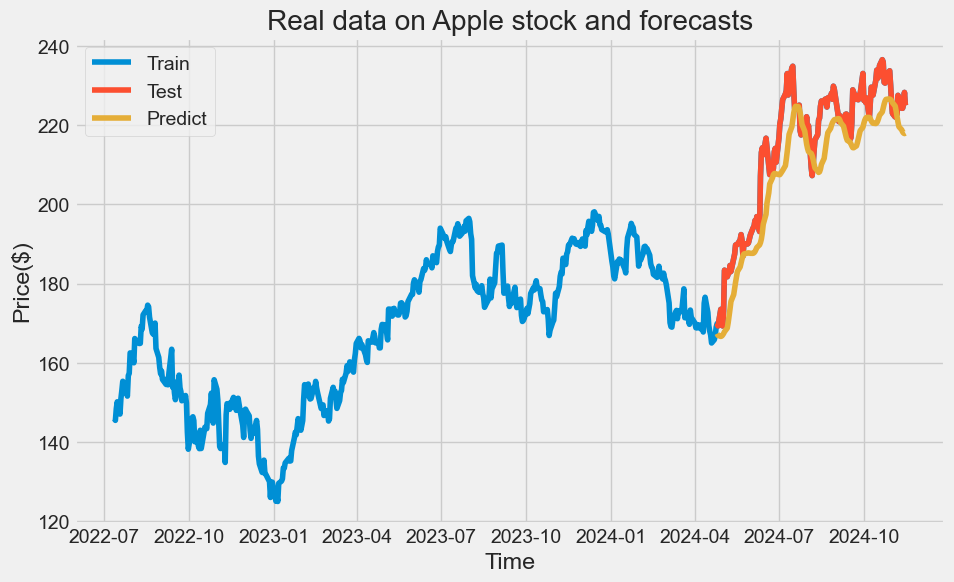

In [55]:
pre_test_lstm = AAPL[training_data_len - 450:]  # Lấy một phần dữ liệu trước khi bắt đầu dự đoán
test_lstm = AAPL[training_data_len:]  # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test_lstm['Prediction'] = predictions_lstm  # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test_lstm['Close'])
plt.plot(test_lstm[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Apple stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

### Predict stock prices for 18/11/2024

In [57]:
# Tải mô hình đã huấn luyện
final_model_lstm = load_model("../../LOGS/LSTM+PSO/save_model_train_apples.keras")

next_day = "2024-11-19"  # Lấy ngày 18/11/2024
start = '2023-01-01'  # Xác định thời gian bắt đầu từ năm 2023
AAPL_next_day_lstm = yf.download('AAPL', start = start, end = next_day)  # Tải dữ liệu giá cổ phiếu AAPL từ Yahoo Finance
close_lstm = AAPL_next_day_lstm[AAPL_next_day_lstm.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close_lstm = np.array(close_lstm)  # Chuyển đổi dữ liệu thành mảng numpy
close_lstm = scaler.transform(np.reshape(close_lstm, (close_lstm.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close_lstm = np.reshape(close_lstm, (1, close_lstm.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
last_close_price_lstm = float(AAPL_next_day_lstm.iloc[-1]['Close'])
print(f"Actual Apple stock price 18/11/2024: {last_close_price_lstm}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Apple stock price prediction for 18/11/2024: {scaler.inverse_transform(final_model_lstm.predict(close_lstm))[0][0]}')

[*********************100%***********************]  1 of 1 completed

Actual Apple stock price 18/11/2024: 226.9933624267578


ValueError: in user code:

    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 60, 1), found shape=(None, 90, 1)


## Amazon

### Evaluating model

In [58]:
# Get the models predicted price values
final_model_amz_lstm = load_model("../../LOGS/LSTM+PSO/save_model_train_amazons.keras")
predictions_amz_lstm = final_model_amz_lstm.predict(AMZN_test_x)
predictions_amz_lstm = scaler_amz.inverse_transform(predictions_amz_lstm)

# Get the root mean squared error (RMSE)
print('R2: ',r2_score(AMZN_test_y,predictions_amz_lstm))
print('MAE: ',mean_absolute_error(AMZN_test_y,predictions_amz_lstm))
print('MSE: ',mean_squared_error(AMZN_test_y,predictions_amz_lstm))
print('RMSE: ',np.sqrt(mean_squared_error(AMZN_test_y, predictions_amz_lstm)))
print('MAPE:', mean_absolute_percentage_error(AMZN_test_y,predictions_amz_lstm))

5/5 [==============================] - 1s 51ms/step
R2:  0.519509864766142
MAE:  5.299311497828343
MSE:  44.75724299694249
RMSE:  6.690085425235053
MAPE: 0.028977406101255914


### Plot a comparison between actual data and model predictions for Amazon stock

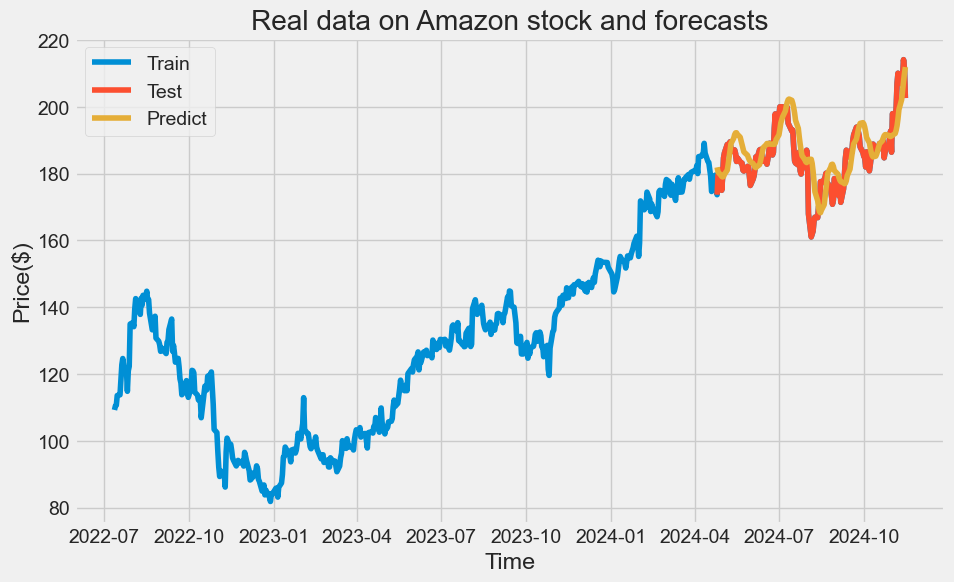

In [59]:
# Plot the test data and predictions
pre_test_amz_lstm = AMZN[training_data_len_amz - 450:] # Lấy một phần dữ liệu trước khi bắt đầu dự đoán
test_amz_lstm = AMZN[training_data_len_amz:] # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test_amz_lstm['Prediction'] = predictions_amz_lstm # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test_amz_lstm['Close'])
plt.plot(test_amz_lstm[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Amazon stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

### Predict stock prices for 18/11/2024

In [60]:
# Tải mô hình đã huấn luyện
final_model_amz_lstm = load_model("../../LOGS/LSTM+PSO/save_model_train_amazons.keras")

next_day_amz = '2024-11-19'  # Lấy ngày 18/11/2024
start = '2023-01-01'  # Xác định thời gian bắt đầu từ năm 2023
AMZN_next_day_lstm = yf.download('AMZN', start = start, end = next_day_amz)  # Tải dữ liệu giá cổ phiếu AMZN từ Yahoo Finance
close_amz_lstm = AMZN_next_day_lstm[AMZN_next_day_lstm.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close_amz_lstm = np.array(close_amz_lstm)  # Chuyển đổi dữ liệu thành mảng numpy
close_amz_lstm = scaler_amz.transform(np.reshape(close_amz_lstm, (close_amz_lstm.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close_amz_lstm = np.reshape(close_amz_lstm, (1, close_amz_lstm.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
last_close_price_amz_lstm = float(AMZN_next_day_lstm.iloc[-1]['Close'])
print(f"Actual Amazon stock price 18/11/2024: {last_close_price_amz_lstm}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Amazon stock price prediction for 18/11/2024: {scaler_amz.inverse_transform(final_model_amz_lstm.predict(close_amz_lstm))[0][0]}')

[*********************100%***********************]  1 of 1 completed


Actual Amazon stock price 18/11/2024: 201.6999969482422
1/1 [==============================] - 1s 618ms/step
Amazon stock price prediction for 18/11/2024: 212.6512908935547


## Google

### Evaluating Model

In [61]:
# Get the models predicted price values
final_model_gg_lstm = load_model("../../LOGS/LSTM+PSO/save_model_train_googles.keras")
predictions_gg_lstm = final_model_gg_lstm.predict(GOOG_test_x)
predictions_gg_lstm = scaler_gg.inverse_transform(predictions_gg_lstm)

print('R2: ',r2_score(GOOG_test_y,predictions_gg_lstm))
print('MAE: ',mean_absolute_error(GOOG_test_y,predictions_gg_lstm))
print('MSE: ',mean_squared_error(GOOG_test_y,predictions_gg_lstm))
print('RMSE: ',np.sqrt(mean_squared_error(GOOG_test_y, predictions_gg_lstm)))
print('MAPE:', mean_absolute_percentage_error(GOOG_test_y,predictions_gg_lstm))

5/5 [==============================] - 1s 49ms/step
R2:  0.5191580575523962
MAE:  5.021099277309604
MSE:  38.9040214928743
RMSE:  6.237308834174744
MAPE: 0.029395226082072477


### Plot a comparison between actual data and model predictions for Google stock

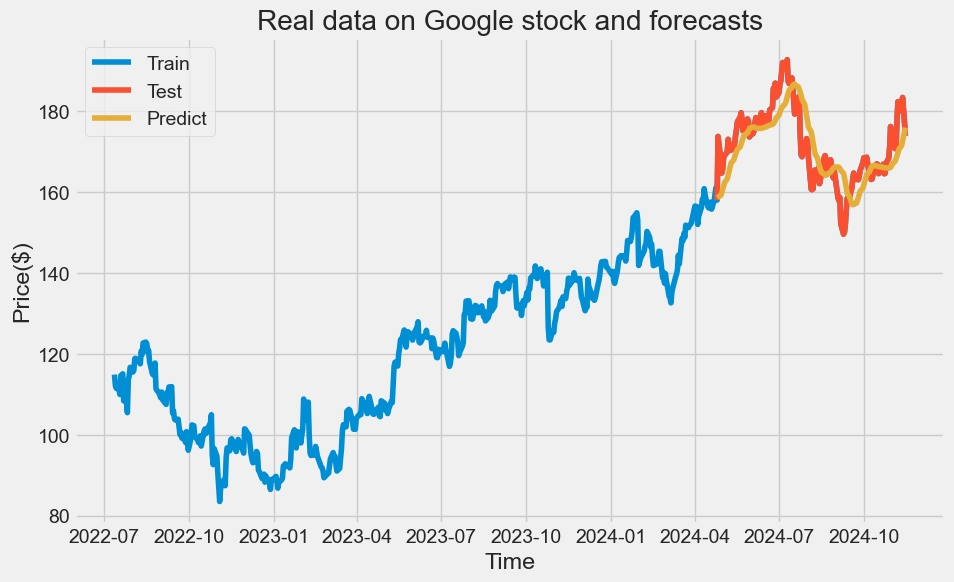

In [62]:
# Plot the test data and predictions
pre_test_gg_lstm = GOOG[training_data_len_gg - 450:] # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế
test_gg_lstm = GOOG[training_data_len_gg:] # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test_gg_lstm['Prediction'] = predictions_gg_lstm # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test_gg_lstm['Close'])
plt.plot(test_gg_lstm[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Google stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

### Predict stock prices for 18/11/2024

In [63]:
# Tải mô hình đã huấn luyện
final_model_gg_lstm = load_model("../../LOGS/LSTM+PSO/save_model_train_googles.keras")

next_day = '2024-11-19'  # Lấy ngày 18/11/2024
start = '2023-01-01'  # Xác định thời gian bắt đầu từ năm 2023
GOOG_next_day_lstm = yf.download('GOOG', start = start, end = next_day)  # Tải dữ liệu giá cổ phiếu GOOG từ Yahoo Finance
close_gg_lstm = GOOG_next_day_lstm[GOOG_next_day_lstm.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close_gg_lstm = np.array(close_gg_lstm)  # Chuyển đổi dữ liệu thành mảng numpy
close_gg_lstm = scaler_gg.transform(np.reshape(close_gg_lstm, (close_gg_lstm.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close_gg_lstm = np.reshape(close_gg_lstm, (1, close_gg_lstm.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
last_close_price_gg_lstm = float(GOOG_next_day_lstm.iloc[-1]['Close'])
print(f"Actual Google stock price 18/11/2024: {last_close_price_gg_lstm}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Google stock price prediction for 18/11/2024: {scaler_gg.inverse_transform(final_model_gg_lstm.predict(close_gg_lstm))[0][0]}')

[*********************100%***********************]  1 of 1 completed


Actual Google stock price 18/11/2024: 175.91481018066406
1/1 [==============================] - 1s 627ms/step
Google stock price prediction for 18/11/2024: 176.40440368652344


## Vinamilk

### Evaluating Model

In [64]:
# Get the models predicted price values
final_model_vnm_lstm = load_model("../../LOGS/LSTM+PSO/save_model_vnms.keras")
predictions_vnm_lstm = final_model_vnm_lstm.predict(VNM_test_x)
predictions_vnm_lstm = scaler_vnm.inverse_transform(predictions_vnm_lstm)

print('R2: ',r2_score(VNM_test_y,predictions_vnm_lstm))
print('MAE: ',mean_absolute_error(VNM_test_y,predictions_vnm_lstm))
print('MSE: ',mean_squared_error(VNM_test_y,predictions_vnm_lstm))
print('RMSE: ',np.sqrt(mean_squared_error(VNM_test_y, predictions_vnm_lstm)))
print('MAPE:', mean_absolute_percentage_error(VNM_test_y,predictions_vnm_lstm))

2025-12-14 22:02:52,355 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BC8DA497E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 [==============================] - 1s 49ms/step
R2:  0.6843093554719949
MAE:  1234.5276817375886
MSE:  3090703.16418676
RMSE:  1758.0395798123432
MAPE: 0.01844685738078167


### Plot a comparison between actual data and model predictions for Vinamilk stock

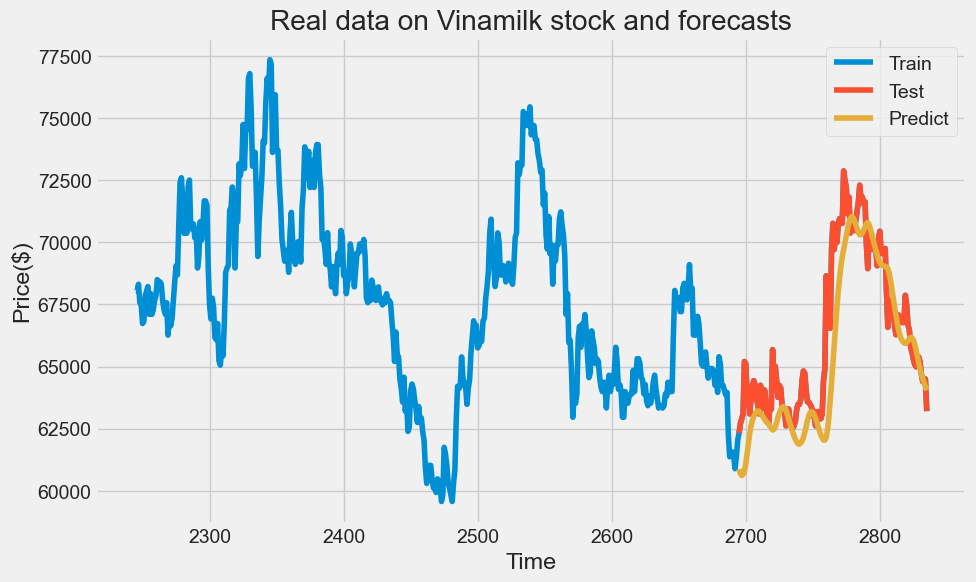

In [65]:
# Plot the test data and predictions
pre_test_vnm_lstm = df_vnm[training_data_len_vnm - 450:] # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế
test_vnm_lstm = df_vnm[training_data_len_vnm:] # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test_vnm_lstm['Prediction'] = predictions_vnm_lstm # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test_vnm_lstm['Close'])
plt.plot(test_vnm_lstm[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Vinamilk stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

### Predict stock prices for 18/11/2024

In [67]:
# Tải mô hình đã huấn luyện
final_model_vnm_lstm = load_model("../../LOGS/LSTM+PSO/save_model_vnms.keras")
VNM_next_day_lstm = df_vnm.copy() # Tạo một bản sao của dữ liệu gốc để tránh thay đổi dữ liệu gốc trong quá trình xử lý.
close_vnm_lstm = VNM_next_day_lstm[VNM_next_day_lstm.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close_vnm_lstm = np.array(close_vnm_lstm)  # Chuyển đổi dữ liệu thành mảng numpy
close_vnm_lstm = scaler_vnm.transform(np.reshape(close_vnm_lstm, (close_vnm_lstm.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close_vnm_lstm = np.reshape(close_vnm_lstm, (1, close_vnm_lstm.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
df_16 = pd.read_csv('../../DATASET/PRICE/Vinamilk_Stock_Adjusted_02.csv')
last_close_price_vnm_lstm = df_16['Close'].iloc[0]
print(f"Actual Vinamilk stock price 18/11/2024: {last_close_price_vnm_lstm}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Vinamilk stock price prediction for 18/11/2024: {scaler_vnm.inverse_transform(final_model_vnm_lstm.predict(close_vnm_lstm))[0][0]}')

Actual Vinamilk stock price 18/11/2024: 62709.3
1/1 [==============================] - 1s 628ms/step
Vinamilk stock price prediction for 18/11/2024: 63875.69921875


# Result LSTM_PSO Model

## Apple

### Evaluating the LSTM_PSO model

In [68]:
final_model = load_model("../../LOGS/LSTM+PSO/save_model_train_apple_bests.keras")
# Đánh giá mô hình
predictions = final_model.predict(AAPL_test_x)
predictions = scaler.inverse_transform(predictions)

print('R2:', r2_score(AAPL_test_y, predictions))
print('MAE:', mean_absolute_error(AAPL_test_y, predictions))
print('MSE:', mean_squared_error(AAPL_test_y, predictions))
print('RMSE:', np.sqrt(mean_squared_error(AAPL_test_y, predictions)))
print('MAPE:', mean_absolute_percentage_error(AAPL_test_y, predictions))

2025-12-14 22:03:51,530 - tensorflow - WARNING - 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001BCAF5F9480> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 [==============================] - 1s 27ms/step
R2: 0.6180489683023711
MAE: 9.03255414629316
MSE: 113.78748868536074
RMSE: 10.667121855747254
MAPE: 0.04189623830585468


### Plot a comparison between actual data and model predictions for Apple stock

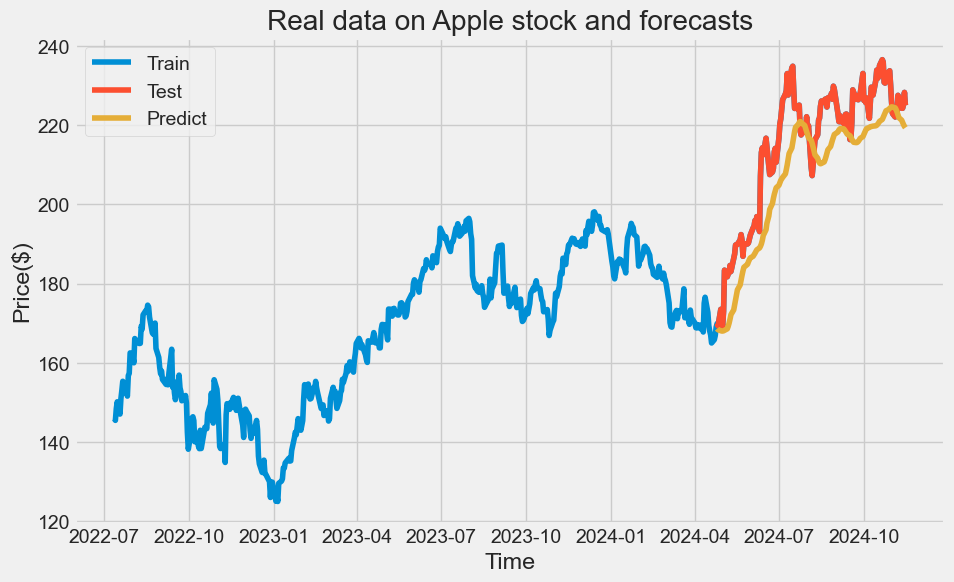

In [69]:
pre_test = AAPL[training_data_len - 450:]  # Lấy một phần dữ liệu trước khi bắt đầu dự đoán
test = AAPL[training_data_len:]  # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test['Prediction'] = predictions  # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test['Close'])
plt.plot(test[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Apple stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

### Predict stock prices for 18/11/2024

In [70]:
# Tải mô hình đã huấn luyện
final_model = load_model("../../LOGS/LSTM+PSO/save_model_train_apple_bests.keras")

next_day = "2024-11-19"  # Lấy ngày 18/11/2024
start = '2023-01-01'  # Xác định thời gian bắt đầu từ năm 2023
AAPL_next_day = yf.download('AAPL', start = start, end = next_day)  # Tải dữ liệu giá cổ phiếu AAPL từ Yahoo Finance
close = AAPL_next_day[AAPL_next_day.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close = np.array(close)  # Chuyển đổi dữ liệu thành mảng numpy
close = scaler.transform(np.reshape(close, (close.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close = np.reshape(close, (1, close.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
last_close_price = float(AAPL_next_day.iloc[-1]['Close'])
print(f"Actual Apple stock price 18/11/2024: {last_close_price}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Apple stock price prediction for 18/11/2024: {scaler.inverse_transform(final_model.predict(close))[0][0]}')

[*********************100%***********************]  1 of 1 completed

Actual Apple stock price 18/11/2024: 226.9933624267578


ValueError: in user code:

    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_16" is incompatible with the layer: expected shape=(None, 60, 1), found shape=(None, 90, 1)


## Amazon

### Evaluating the LSTM_PSO model

In [71]:
final_model_amz = load_model("../../LOGS/LSTM+PSO/save_model_train_amazon_bests.keras")
# Đánh giá mô hình
predictions_amz = final_model_amz.predict(AMZN_test_x)
predictions_amz = scaler_amz.inverse_transform(predictions_amz)
print('R2:', r2_score(AMZN_test_y, predictions_amz))
print('MAE:', mean_absolute_error(AMZN_test_y, predictions_amz))
print('MSE:', mean_squared_error(AMZN_test_y, predictions_amz))
print('RMSE:', np.sqrt(mean_squared_error(AMZN_test_y, predictions_amz)))
print('MAPE:', mean_absolute_percentage_error(AMZN_test_y, predictions_amz))

5/5 [==============================] - 1s 47ms/step
R2: 0.024590375113969443
MAE: 7.8214855060710775
MSE: 90.85856795235263
RMSE: 9.531976078041353
MAPE: 0.043007685029793456


### Plot a comparison between actual data and model predictions for Amazon stock

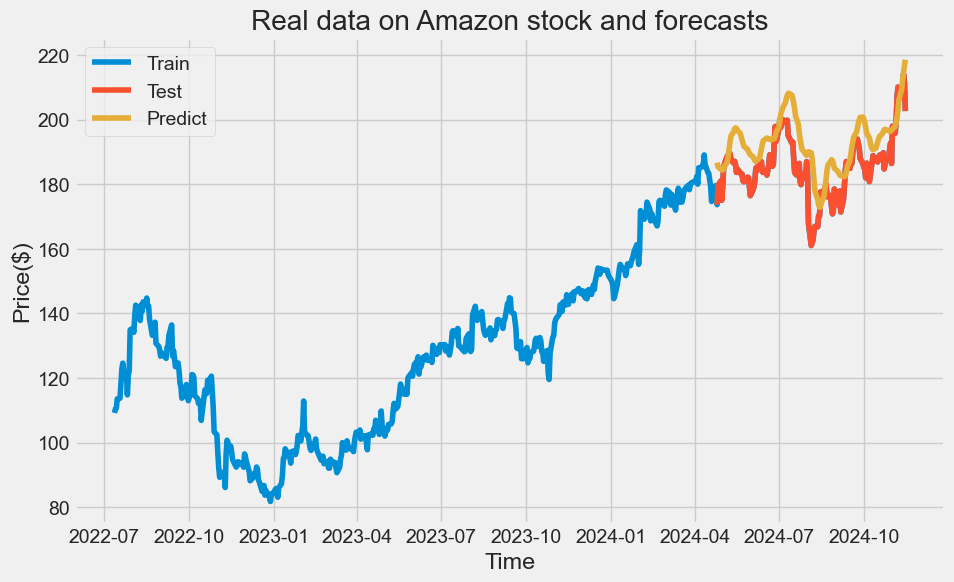

In [72]:
# Plot the test data and predictions
pre_test_amz = AMZN[training_data_len_amz - 450:] # Lấy một phần dữ liệu trước khi bắt đầu dự đoán
test_amz = AMZN[training_data_len_amz:] # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test_amz['Prediction'] = predictions_amz # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test_amz['Close'])
plt.plot(test_amz[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Amazon stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

### Predict stock prices for 18/11/2024

In [73]:
# Tải mô hình đã huấn luyện
final_model_amz = load_model("../../LOGS/LSTM+PSO/save_model_train_amazon_bests.keras")

next_day = '2024-11-19'  # Lấy ngày 18/11/2024
start = '2023-01-01'  # Xác định thời gian bắt đầu từ năm 2023
AMZN_next_day = yf.download('AMZN', start = start, end = next_day)  # Tải dữ liệu giá cổ phiếu AMZN từ Yahoo Finance
close_amz = AMZN_next_day[AMZN_next_day.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close_amz = np.array(close_amz)  # Chuyển đổi dữ liệu thành mảng numpy
close_amz = scaler_amz.transform(np.reshape(close_amz, (close_amz.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close_amz = np.reshape(close_amz, (1, close_amz.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
last_close_price_amz = float(AMZN_next_day.iloc[-1]['Close'])
print(f"Actual Amazon stock price 18/11/2024: {last_close_price_amz}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Amazon stock price prediction for 18/11/2024: {scaler_amz.inverse_transform(final_model_amz.predict(close_amz))[0][0]}')

[*********************100%***********************]  1 of 1 completed


Actual Amazon stock price 18/11/2024: 201.6999969482422
1/1 [==============================] - 1s 635ms/step
Amazon stock price prediction for 18/11/2024: 218.58477783203125


## Google

### Evaluating the LSTM_PSO model

In [74]:
final_model_gg = load_model("../../LOGS/LSTM+PSO/save_model_train_google_bests.keras")
# Đánh giá mô hình
predictions_gg = final_model_gg.predict(GOOG_test_x)
predictions_gg = scaler_gg.inverse_transform(predictions_gg)
print('R2:', r2_score(GOOG_test_y, predictions_gg))
print('MAE:', mean_absolute_error(GOOG_test_y, predictions_gg))
print('MSE:', mean_squared_error(GOOG_test_y, predictions_gg))
print('RMSE:', np.sqrt(mean_squared_error(GOOG_test_y, predictions_gg)))
print('MAPE:', mean_absolute_percentage_error(GOOG_test_y, predictions_gg))

OSError: No file or directory found at ../../LOGS/LSTM+PSO/save_model_train_google_bests.keras

### Plot a comparison between actual data and model predictions for Google stock

In [75]:
# Plot the test data and predictions
pre_test_gg = GOOG[training_data_len_gg - 450:] # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế
test_gg = GOOG[training_data_len_gg:] # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test_gg['Prediction'] = predictions_gg # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test_gg['Close'])
plt.plot(test_gg[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Google stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

NameError: name 'predictions_gg' is not defined

### Predict stock prices for 18/11/2024

In [76]:
# Tải mô hình đã huấn luyện
final_model_gg = load_model("../../LOGS/LSTM+PSO/save_model_train_google_bests.keras")

next_day = '2024-11-19'  # Lấy ngày 18/11/2024
start = '2023-01-01'  # Xác định thời gian bắt đầu từ năm 2023
GOOG_next_day = yf.download('GOOG', start = start, end = next_day)  # Tải dữ liệu giá cổ phiếu GOOG từ Yahoo Finance
close_gg = GOOG_next_day[GOOG_next_day.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close_gg = np.array(close_gg)  # Chuyển đổi dữ liệu thành mảng numpy
close_gg = scaler_gg.transform(np.reshape(close_gg, (close_gg.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close_gg = np.reshape(close_gg, (1, close_gg.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
last_close_price_gg = float(GOOG_next_day.iloc[-1]['Close'])
print(f"Actual Google stock price 18/11/2024: {last_close_price_gg}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Google stock price prediction for 18/11/2024: {scaler_gg.inverse_transform(final_model_gg.predict(close_gg))[0][0]}')

OSError: No file or directory found at ../../LOGS/LSTM+PSO/save_model_train_google_bests.keras

## Vinamilk

### Evaluating the LSTM_PSO model

In [77]:
model_vnm = load_model("../../LOGS/LSTM+PSO/save_model_train_vnm_bests.keras")
# Đánh giá mô hình
predictions_vnm = model_vnm.predict(VNM_test_x)
predictions_vnm = scaler_vnm.inverse_transform(predictions_vnm)
print('R2:', r2_score(VNM_test_y, predictions_vnm))
print('MAE:', mean_absolute_error(VNM_test_y, predictions_vnm))
print('MSE:', mean_squared_error(VNM_test_y, predictions_vnm))
print('RMSE:', np.sqrt(mean_squared_error(VNM_test_y, predictions_vnm)))
print('MAPE:', mean_absolute_percentage_error(VNM_test_y, predictions_vnm))

5/5 [==============================] - 1s 53ms/step
R2: 0.38446343026311713
MAE: 2254.8644669769506
MSE: 6026281.921033239
RMSE: 2454.84865542323
MAPE: 0.03428358203546859


### Plot a comparison between actual data and model predictions for Google stock

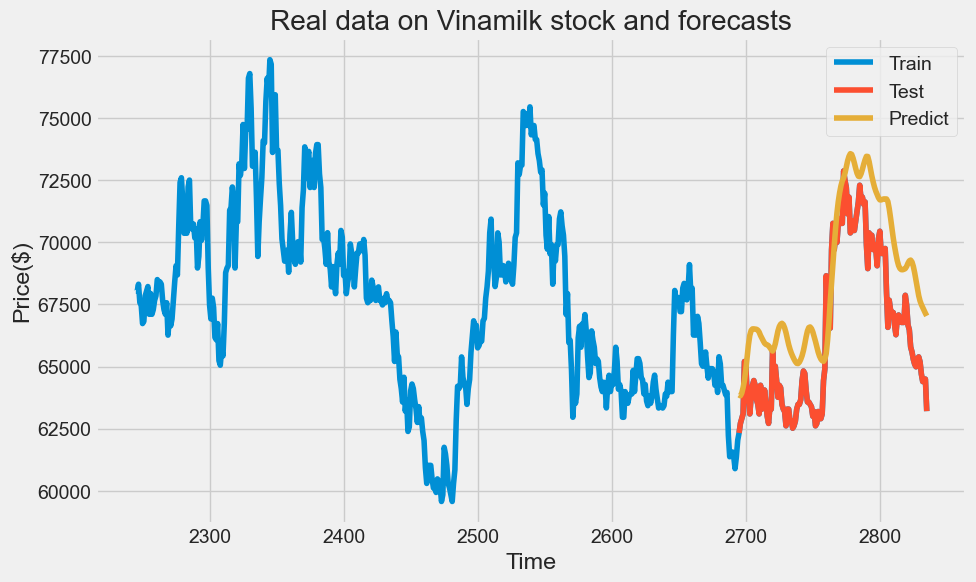

In [78]:
# Plot the test data and predictions
pre_test_vnm = df_vnm[training_data_len_vnm - 450:] # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế
test_vnm = df_vnm[training_data_len_vnm:] # Lấy phần dữ liệu test, nơi mà dự đoán sẽ được thực hiện
test_vnm['Prediction'] = predictions_vnm # Thêm cột 'Prediction' vào dữ liệu test để so sánh với giá trị thực tế

plt.figure(figsize = (10,6))
plt.plot(pre_test_vnm['Close'])
plt.plot(test_vnm[['Close', 'Prediction']])
plt.xlabel('Time')
plt.ylabel('Price($)')
plt.title('Real data on Vinamilk stock and forecasts')
plt.legend(['Train','Test', 'Predict'], loc = 'best')
plt.show()

### Predict stock prices for 18/11/2024

In [ ]:
# Tải mô hình đã huấn luyện
final_model_vnm = load_model("../../LOGS/LSTM+PSO/save_model_train_vnm_bests.keras")
VNM_next_day = df_vnm.copy() # Tạo một bản sao của dữ liệu gốc để tránh thay đổi dữ liệu gốc trong quá trình xử lý.
close_vnm = VNM_next_day[VNM_next_day.shape[0] - pre_days :]['Close'].values  # Lấy giá đóng cửa của những ngày gần nhất (pre_days)
close_vnm = np.array(close_vnm)  # Chuyển đổi dữ liệu thành mảng numpy
close_vnm = scaler_vnm.transform(np.reshape(close_vnm, (close_vnm.shape[0], 1)))  # Chuẩn hóa dữ liệu với scaler
close_vnm = np.reshape(close_vnm, (1, close_vnm.shape[0], 1))  # Reshape lại dữ liệu cho phù hợp với đầu vào của LSTM

#Giá đóng cửa thực tế
df_16 = pd.read_csv('../../DATASET/PRICE/Vinamilk_Stock_Adjusted_02.csv')
last_close_price_vnm = df_16['Close'].iloc[0]
print(f"Actual Vinamilk stock price 18/11/2024: {last_close_price_vnm}")

# Giá trị dự đoán giá cổ phiếu cho ngày 18/11/2024
print(f'Vinamilk stock price prediction for 18/11/2024: {scaler_vnm.inverse_transform(final_model_vnm.predict(close_vnm))[0][0]}')

FileNotFoundError: [Errno 2] No such file or directory: 'Vinamilk_Stock_Adjusted_02.csv'